In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

Figure saved to ../results/Figure/training_dynamics_log_wd0.png


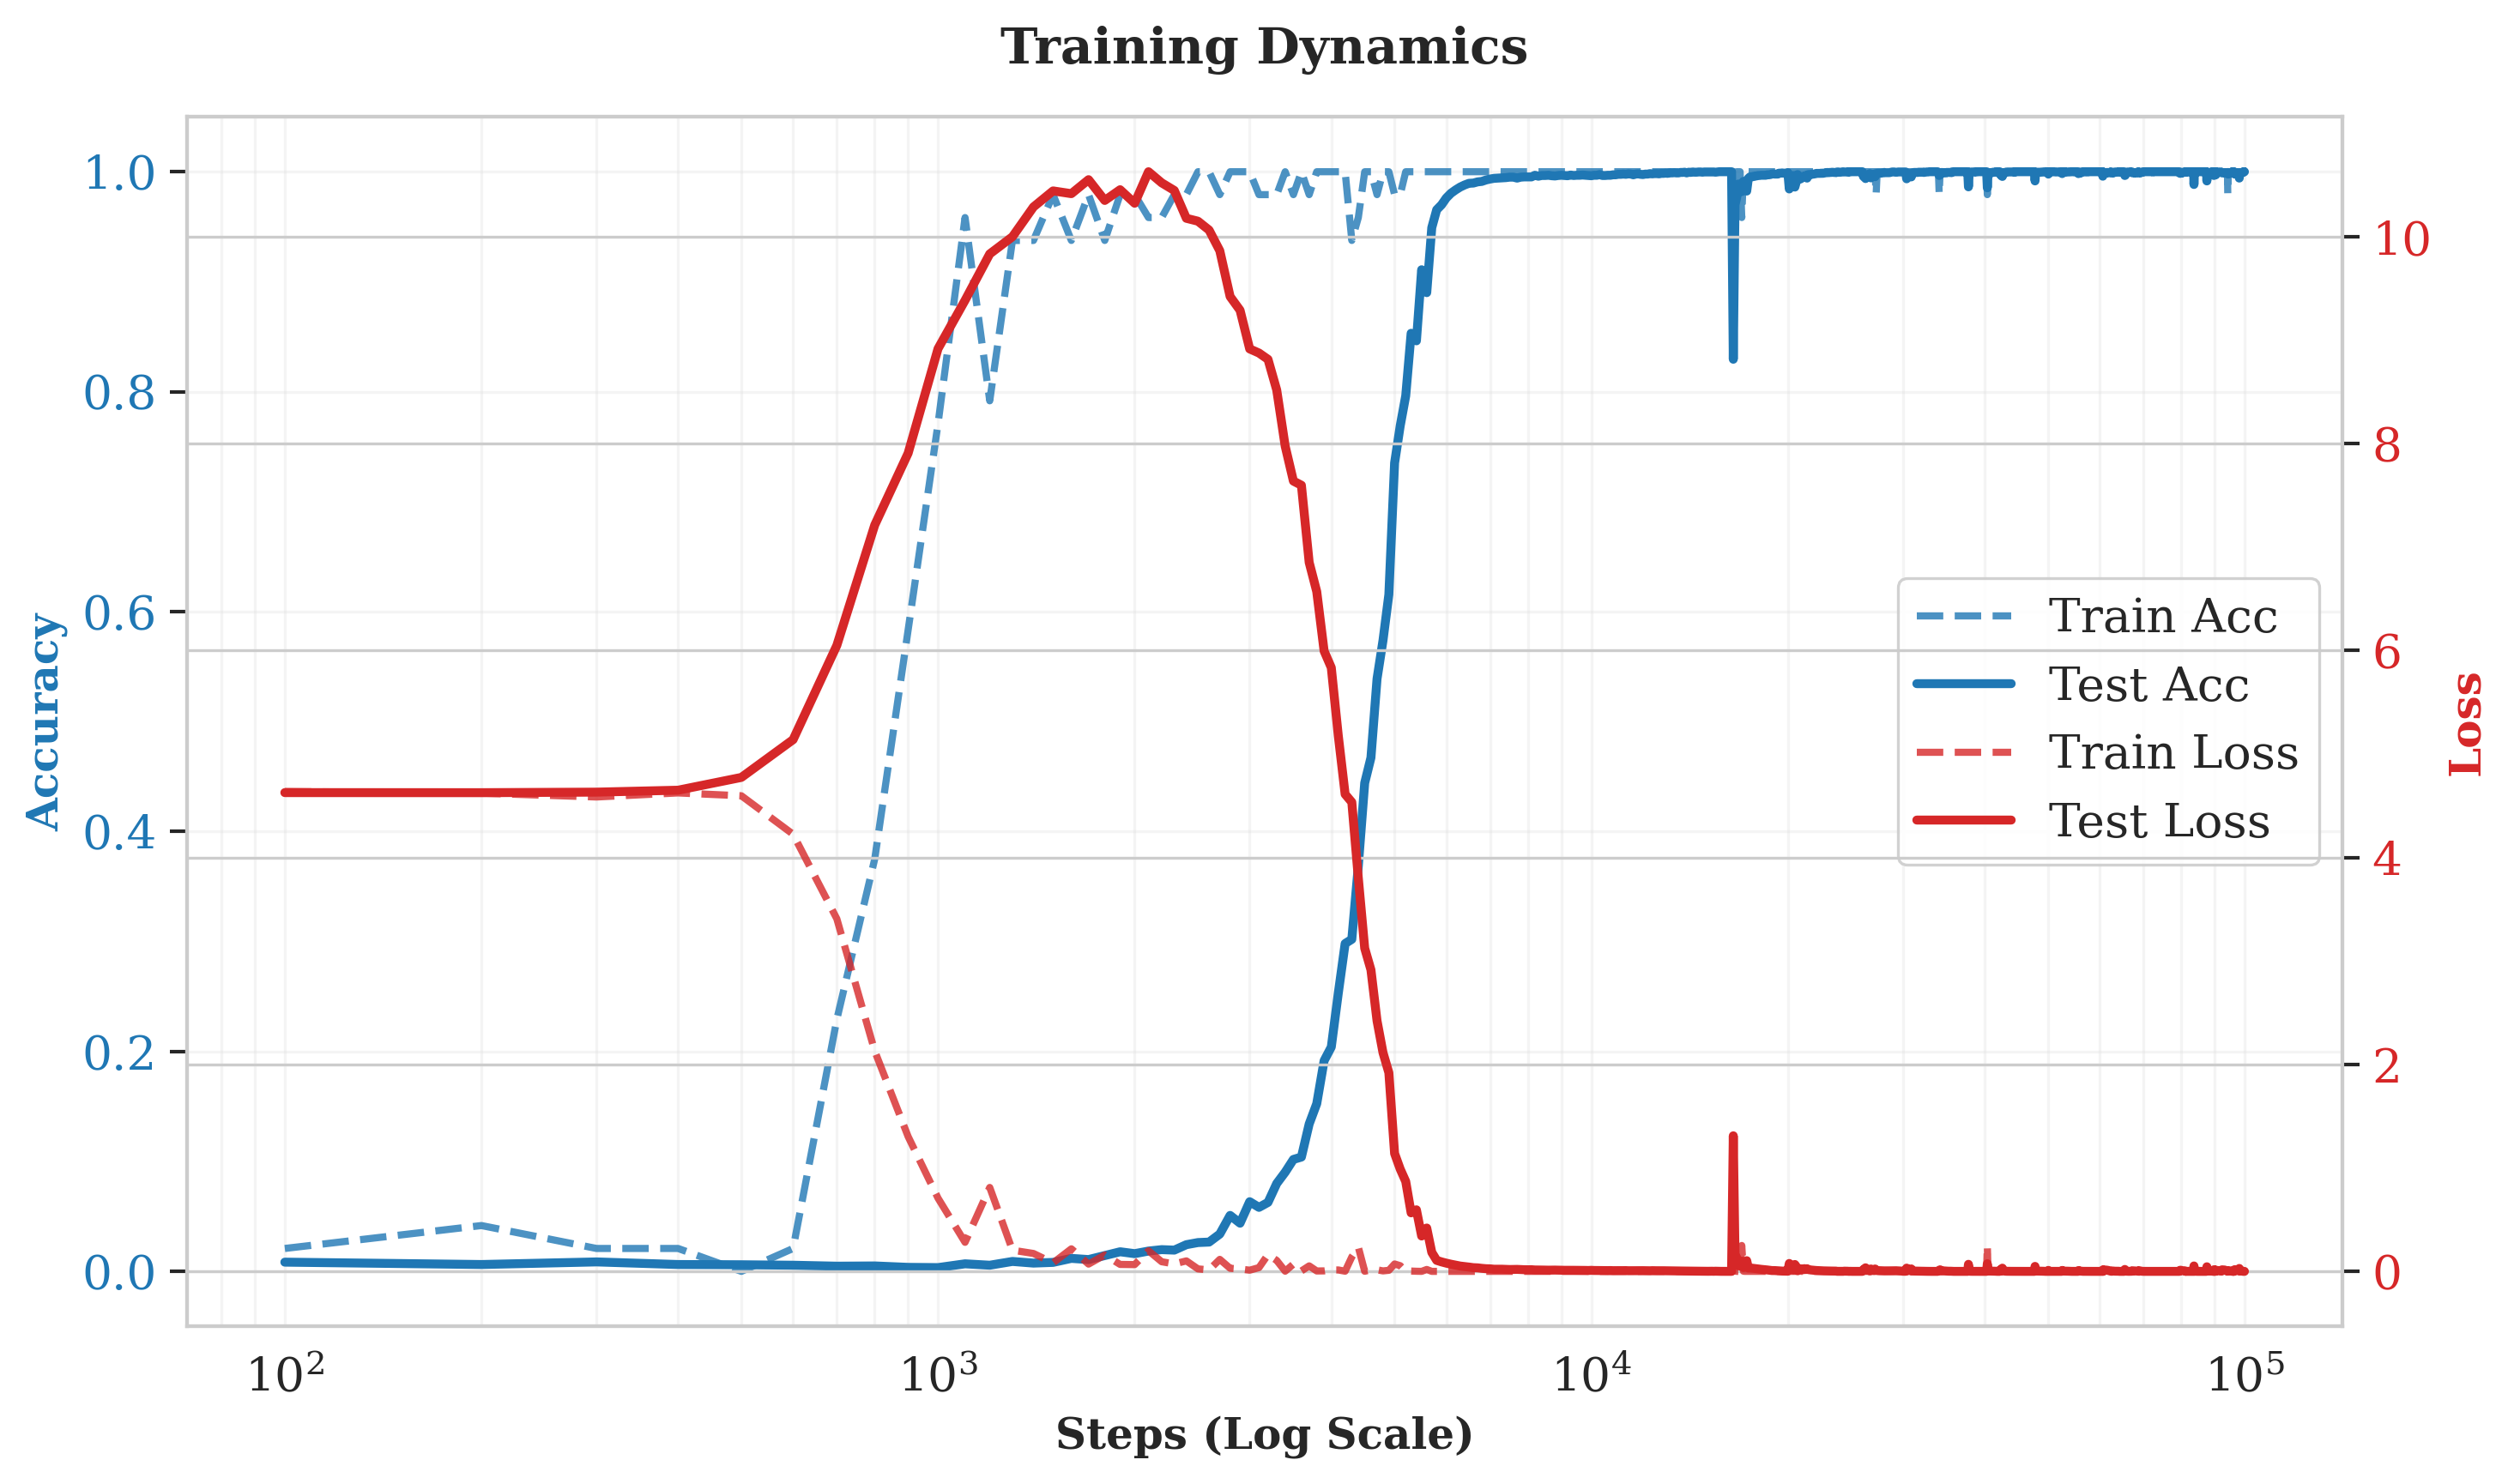

In [3]:
# Configuration for publication-quality figures
sns.set_context("paper", font_scale=1.5)
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 300

# Define Paths
base_dir = "../results/Data/x-y/x_minus_y"
wd0_path = os.path.join(base_dir, "wd_0.0/seed42.csv")

# Setup Figure
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

def plot_metrics(ax, csv_path, title):
    if not os.path.exists(csv_path):
        ax.text(0.5, 0.5, f"Data not found:\n{csv_path}", ha='center', va='center')
        return

    df = pd.read_csv(csv_path)
    
    # Left Axis: Accuracy
    ln1 = ax.plot(df['steps'], df['train_acc'], label='Train Acc', color='#1f77b4', linestyle='--', linewidth=2, alpha=0.8)
    ln2 = ax.plot(df['steps'], df['test_acc'], label='Test Acc', color='#1f77b4', linewidth=2.5)
    
    ax.set_xlabel('Steps (Log Scale)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy', color='#1f77b4', fontsize=12, fontweight='bold')
    ax.tick_params(axis='y', labelcolor='#1f77b4')
    ax.set_ylim(-0.05, 1.05)
    ax.set_xscale('log')
    ax.grid(True, which="both", ls="-", alpha=0.2)

    # Right Axis: Loss
    ax2 = ax.twinx()
    ln3 = ax2.plot(df['steps'], df['train_loss'], label='Train Loss', color='#d62728', linestyle='--', linewidth=2, alpha=0.8)
    ln4 = ax2.plot(df['steps'], df['test_loss'], label='Test Loss', color='#d62728', linewidth=2.5)
    
    ax2.set_ylabel('Loss', color='#d62728', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='#d62728')
    
    # Title & Legend
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    
    # Combine legends
    lines = ln1 + ln2 + ln3 + ln4
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='center right', frameon=True, framealpha=0.9)

# Plotting
plot_metrics(ax, wd0_path, "Training Dynamics")

plt.tight_layout()
save_path = "../results/Figure/training_dynamics_log_wd0.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to {save_path}")
plt.show()

Loading data...
  -> Loaded step 100
  -> Loaded step 1000
  -> Loaded step 10000
  -> Loaded step 100000


/data/zjj/miniconda3/tmp/ipykernel_388589/1847454150.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


Detailed evolution plot saved to ../results/Figure/cma_evolution_wd0_detailed.png


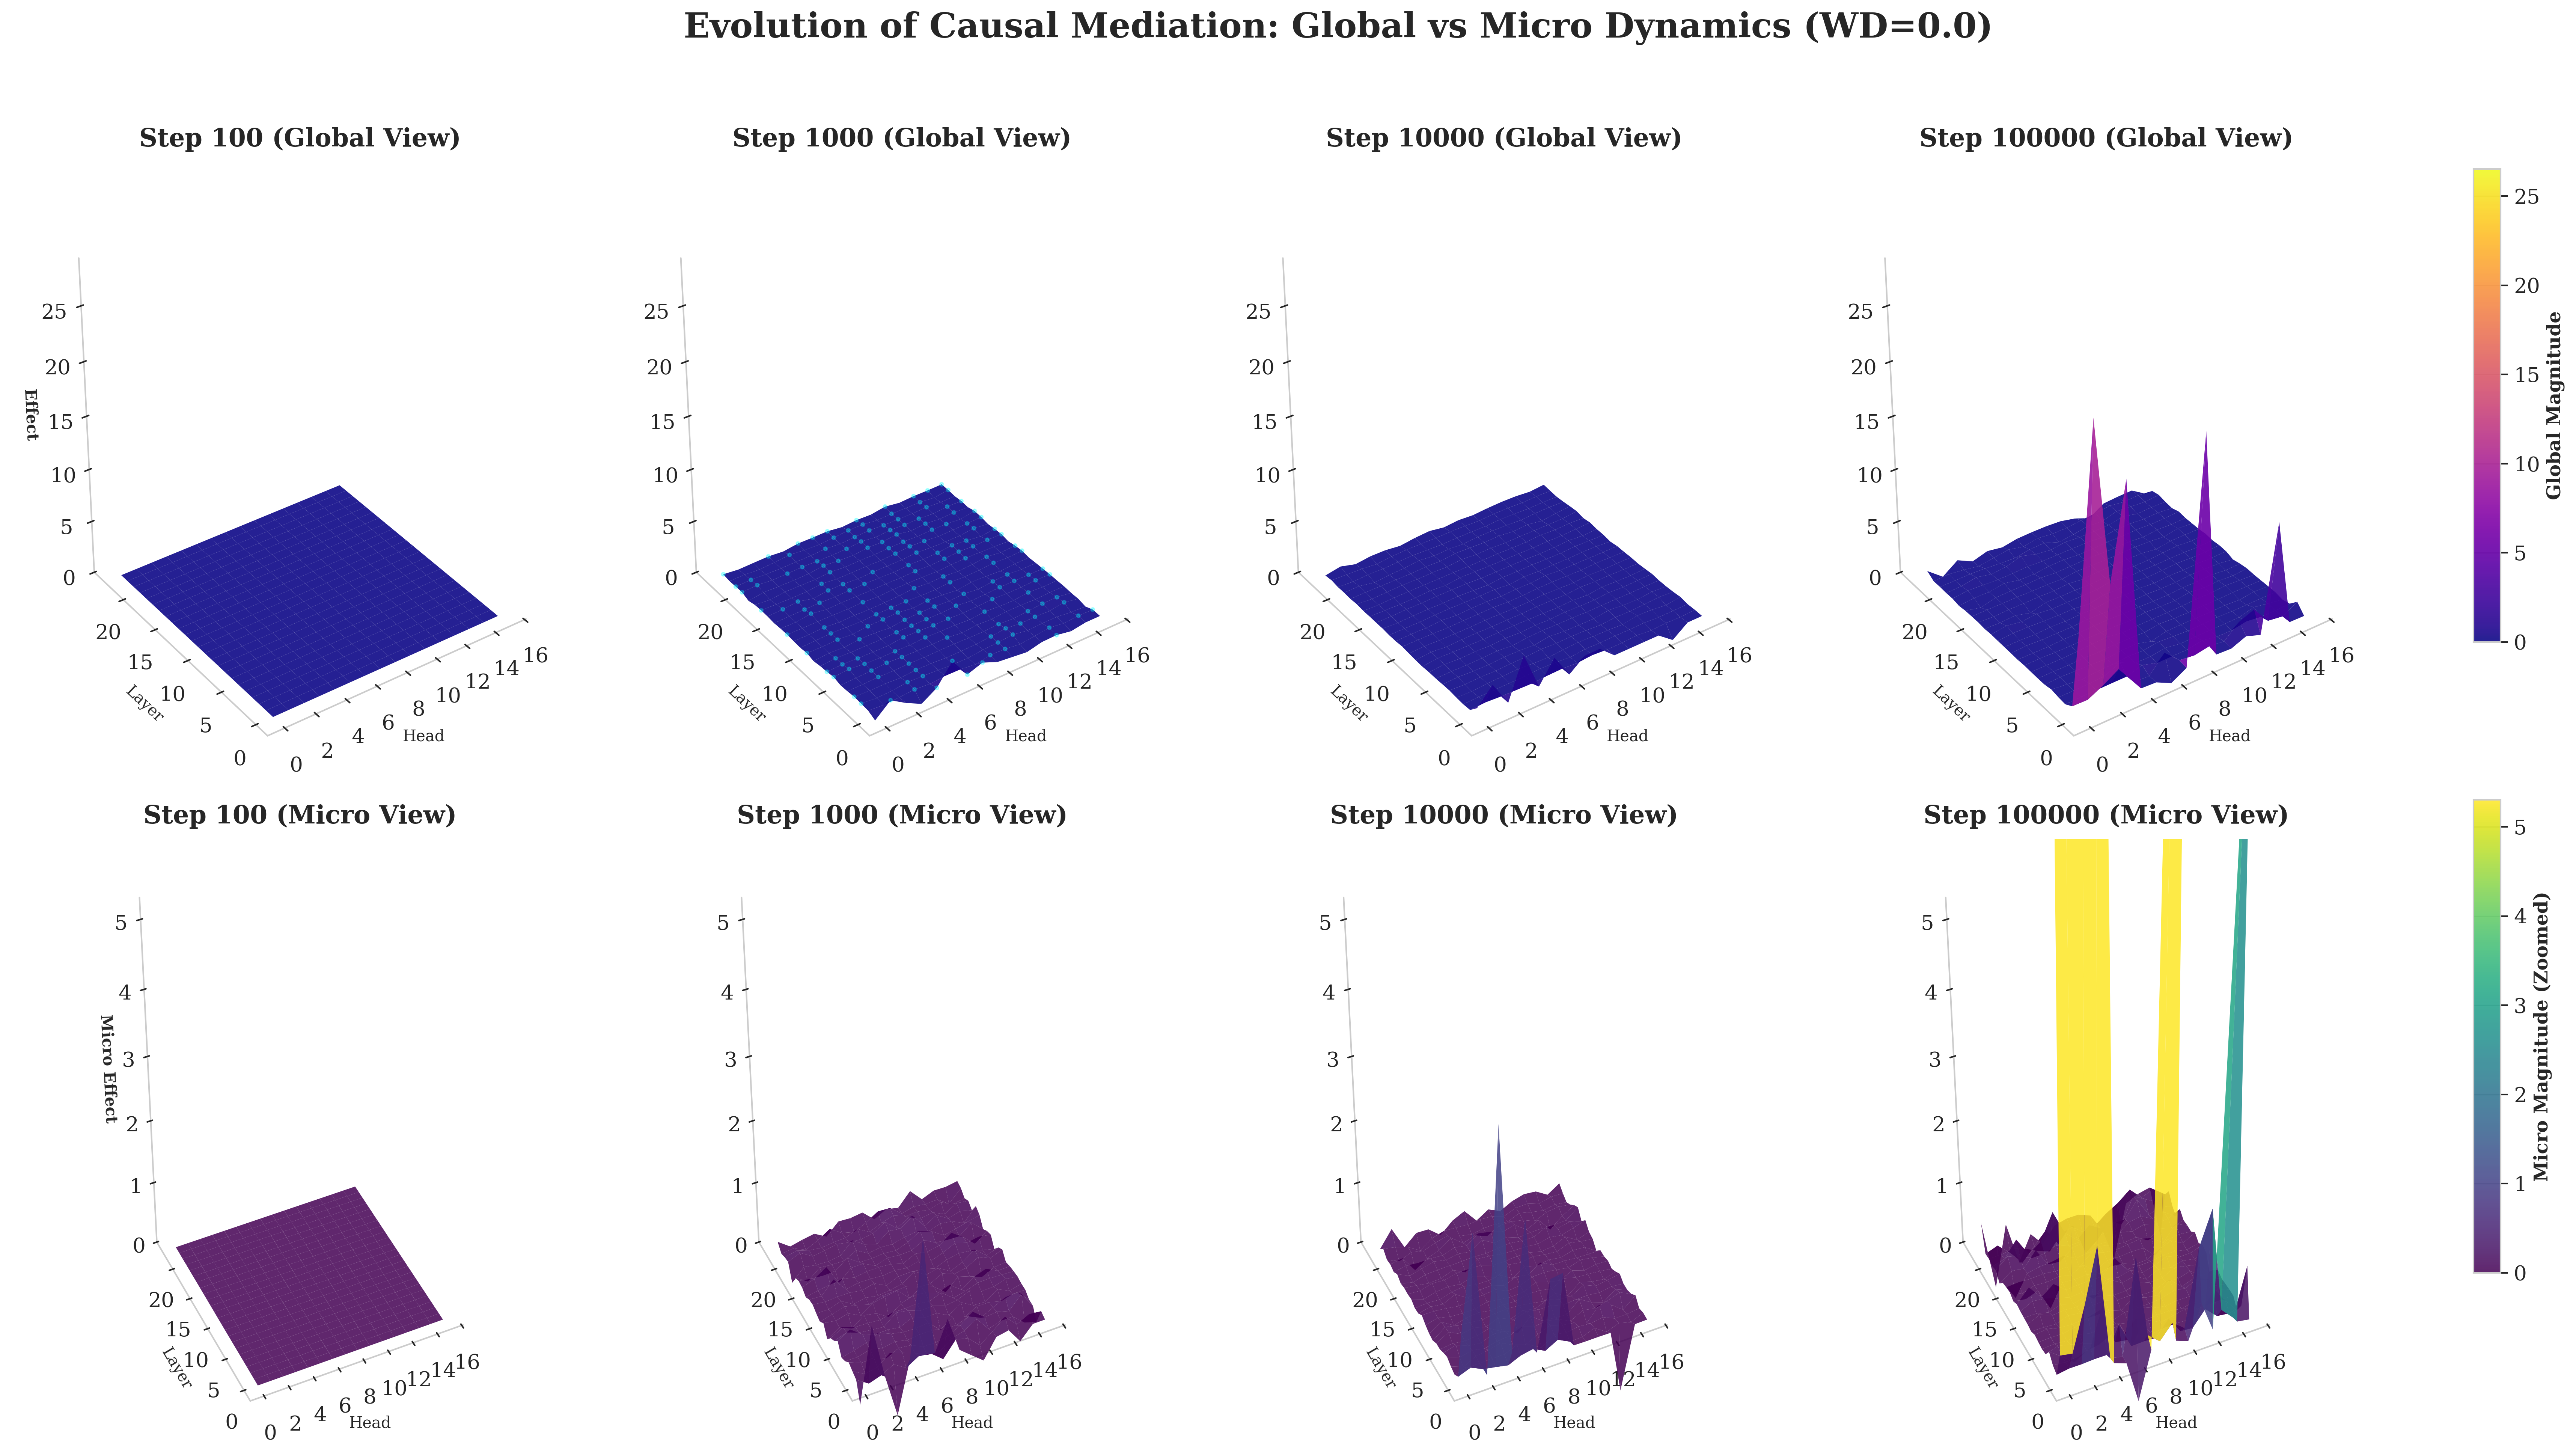

In [9]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LightSource

# Configuration
steps = [100, 1000, 10000, 100000]
base_cma_dir = "/data/zjj/test/results/Data/cma"
sigma_val = 0.3 

# Pre-load data
datasets = {}
raw_datasets = {}
global_max = 0
print("Loading data...")

for step in steps:
    csv_path = os.path.join(base_cma_dir, f"cma_wd_0.0_step_{step}.csv")
    if os.path.exists(csv_path):
        print(f"  -> Loaded step {step}")
        df = pd.read_csv(csv_path, index_col=0)
        data = df.values
        raw_datasets[step] = data
        datasets[step] = gaussian_filter(data, sigma=sigma_val)
        global_max = max(global_max, datasets[step].max())
    else:
        print(f"  [Warn] File not found: {csv_path}")

# Setup Figure (2 rows, 4 columns)
fig = plt.figure(figsize=(24, 14))
ls = LightSource(azdeg=315, altdeg=45)

# --- Row 1: Standard View (Global Scale) ---
for idx, step in enumerate(steps):
    ax = fig.add_subplot(2, 4, idx+1, projection='3d')
    
    if step in datasets:
        data_smooth = datasets[step]
        layers, heads = data_smooth.shape
        X, Y = np.meshgrid(np.arange(heads), np.arange(layers))
        
        # Main Surface
        surf = ax.plot_surface(X, Y, data_smooth, cmap='plasma', 
                               edgecolor='none', alpha=0.9, antialiased=True, 
                               rstride=1, cstride=1, linewidth=0,
                               vmin=0, vmax=global_max, shade=True, lightsource=ls)
        
        # Add Scatter Points for Step 1000 (Chaos Overlay)
        if step == 1000 and 1000 in raw_datasets:
            raw_data = raw_datasets[1000]
            # Filter for low-magnitude "chaos" points to avoid clutter
            mask = (raw_data > 0.01) & (raw_data < global_max * 0.3)
            xs, ys = np.meshgrid(np.arange(heads), np.arange(layers))
            ax.scatter(xs[mask], ys[mask], raw_data[mask], 
                       c='cyan', s=5, alpha=0.3, label='Chaotic Activations')

        # Aesthetics
        ax.set_title(f'Step {step} (Global View)', fontsize=16, fontweight='bold', pad=10)
        ax.set_zlim(0, global_max * 1.1)
        ax.view_init(elev=35, azim=-125)
        ax.set_box_aspect((1, 1, 1.2))
        
        # Clean Look
        ax.grid(False)
        ax.xaxis.pane.fill = False; ax.yaxis.pane.fill = False; ax.zaxis.pane.fill = False
        ax.xaxis.pane.set_edgecolor('w'); ax.yaxis.pane.set_edgecolor('w'); ax.zaxis.pane.set_edgecolor('w')
        
        # Labels only on edges
        if idx == 0:
            ax.set_zlabel('Effect', fontsize=10, fontweight='bold')
        ax.set_xlabel('Head', fontsize=10); ax.set_ylabel('Layer', fontsize=10)

# --- Row 2: Zoomed Z-Axis (Micro View) ---
# Focus on the bottom 20% of the range to see subtle variations
z_micro_limit = global_max * 0.2

for idx, step in enumerate(steps):
    ax = fig.add_subplot(2, 4, idx+5, projection='3d')
    
    if step in datasets:
        data_smooth = datasets[step]
        layers, heads = data_smooth.shape
        X, Y = np.meshgrid(np.arange(heads), np.arange(layers))
        
        # Surface with different colormap for micro variations
        surf_micro = ax.plot_surface(X, Y, data_smooth, cmap='viridis', 
                                     edgecolor='none', alpha=0.85, antialiased=True, 
                                     rstride=1, cstride=1, linewidth=0,
                                     vmin=0, vmax=z_micro_limit, shade=True, lightsource=ls)
        
        # Aesthetics
        ax.set_title(f'Step {step} (Micro View)', fontsize=16, fontweight='bold', pad=10)
        ax.set_zlim(0, z_micro_limit) # Zoom in Z-axis
        ax.view_init(elev=45, azim=-115) # Slightly higher angle
        ax.set_box_aspect((1, 1, 2.0)) # Highly stretched Z
        
        # Clean Look
        ax.grid(False)
        ax.xaxis.pane.fill = False; ax.yaxis.pane.fill = False; ax.zaxis.pane.fill = False
        ax.xaxis.pane.set_edgecolor('w'); ax.yaxis.pane.set_edgecolor('w'); ax.zaxis.pane.set_edgecolor('w')
        
        if idx == 0:
            ax.set_zlabel('Micro Effect', fontsize=10, fontweight='bold')
        ax.set_xlabel('Head', fontsize=10); ax.set_ylabel('Layer', fontsize=10)

# Colorbars
cbar_ax1 = fig.add_axes([0.92, 0.55, 0.01, 0.3])
cbar1 = fig.colorbar(surf, cax=cbar_ax1)
cbar1.set_label('Global Magnitude', fontsize=12, fontweight='bold')

cbar_ax2 = fig.add_axes([0.92, 0.15, 0.01, 0.3])
cbar2 = fig.colorbar(surf_micro, cax=cbar_ax2)
cbar2.set_label('Micro Magnitude (Zoomed)', fontsize=12, fontweight='bold')

plt.suptitle("Evolution of Causal Mediation: Global vs Micro Dynamics (WD=0.0)", fontsize=22, fontweight='bold', y=0.95)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])

save_path_evolution = "../results/Figure/cma_evolution_wd0_detailed.png"
os.makedirs(os.path.dirname(save_path_evolution), exist_ok=True)
plt.savefig(save_path_evolution, dpi=300, bbox_inches='tight')
print(f"Detailed evolution plot saved to {save_path_evolution}")
plt.show()

DFT analysis plot saved to ../results/Figure/dft_analysis_wd1.png


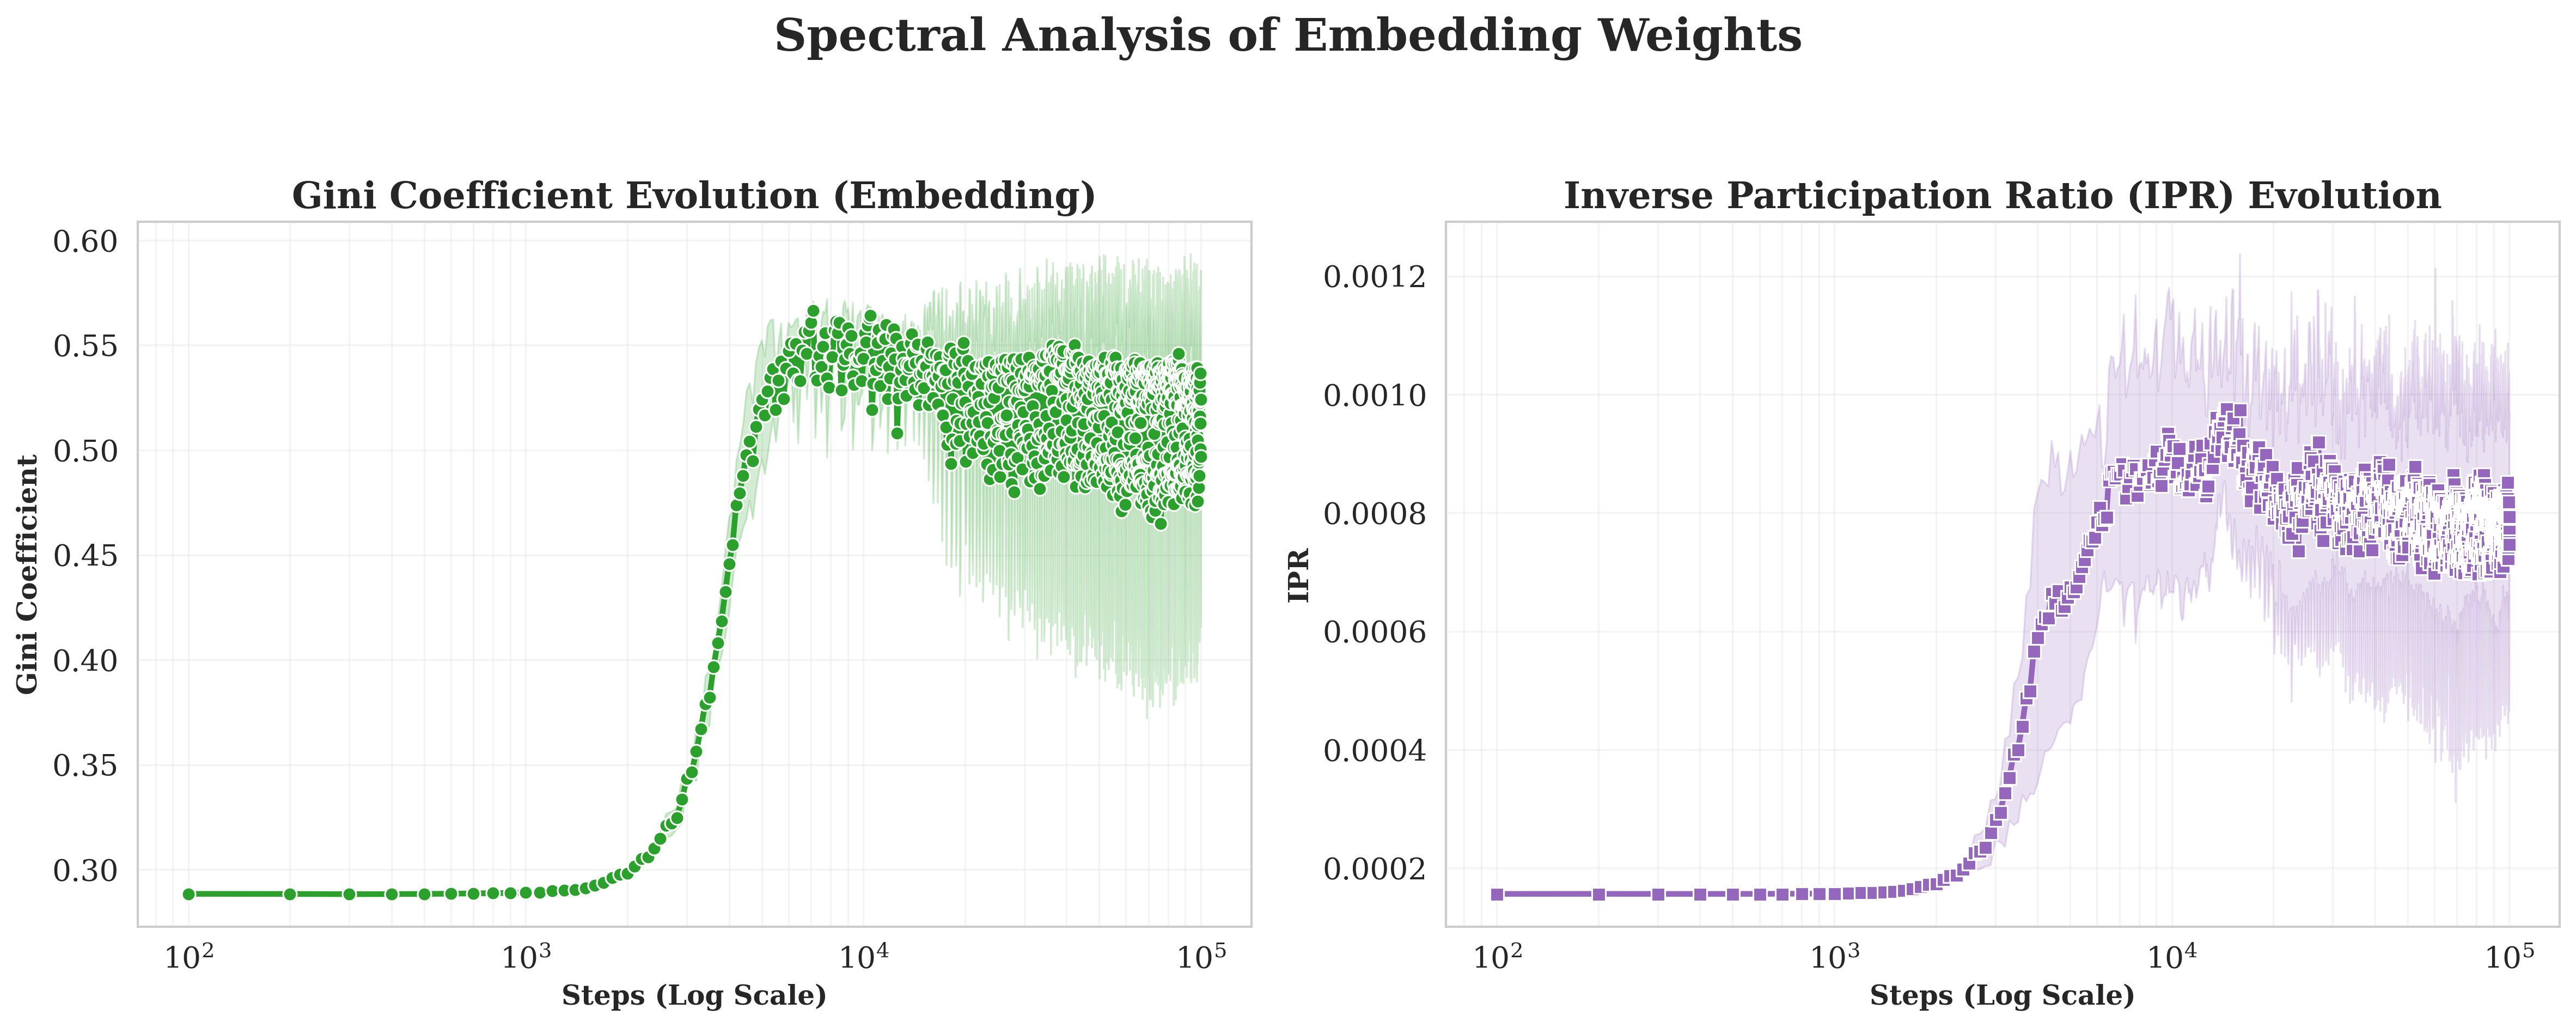

In [14]:
# Load DFT Analysis Data
dft_csv_path = "../results/Data/DFT/dft_analysis_wd1.csv"

if os.path.exists(dft_csv_path):
    df_dft = pd.read_csv(dft_csv_path)
    
    # Setup Figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot Gini Coefficient
    # errorbar='sd' shows the standard deviation across seeds
    sns.lineplot(data=df_dft, x='step', y='gini', ax=axes[0], 
                 color='#2ca02c', linewidth=2.5, marker='o', markersize=6, errorbar='sd')
    axes[0].set_title('Gini Coefficient Evolution (Embedding)', fontsize=16, fontweight='bold')
    axes[0].set_ylabel('Gini Coefficient', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Steps (Log Scale)', fontsize=12, fontweight='bold')
    axes[0].set_xscale('log')
    axes[0].grid(True, which="both", ls="-", alpha=0.2)
    
    # Plot IPR
    sns.lineplot(data=df_dft, x='step', y='ipr', ax=axes[1], 
                 color='#9467bd', linewidth=2.5, marker='s', markersize=6, errorbar='sd')
    axes[1].set_title('Inverse Participation Ratio (IPR) Evolution', fontsize=16, fontweight='bold')
    axes[1].set_ylabel('IPR', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Steps (Log Scale)', fontsize=12, fontweight='bold')
    axes[1].set_xscale('log')
    axes[1].grid(True, which="both", ls="-", alpha=0.2)
    
    plt.suptitle("Spectral Analysis of Embedding Weights", fontsize=20, fontweight='bold', y=1.05)
    plt.tight_layout()
    
    save_path_dft = "../results/Figure/dft_analysis_wd1.png"
    os.makedirs(os.path.dirname(save_path_dft), exist_ok=True)
    plt.savefig(save_path_dft, dpi=300, bbox_inches='tight')
    print(f"DFT analysis plot saved to {save_path_dft}")
    plt.show()
else:
    print(f"Data file not found: {dft_csv_path}. Please run utils/DFT.py first.")

Plotting 3D Manifold for 99 tokens (P=99)...


/data/zjj/miniconda3/tmp/ipykernel_388589/2910663355.py:68: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Saved 3D plot to ../results/Figure/manifold_evolution_pca_wd1_clean.png


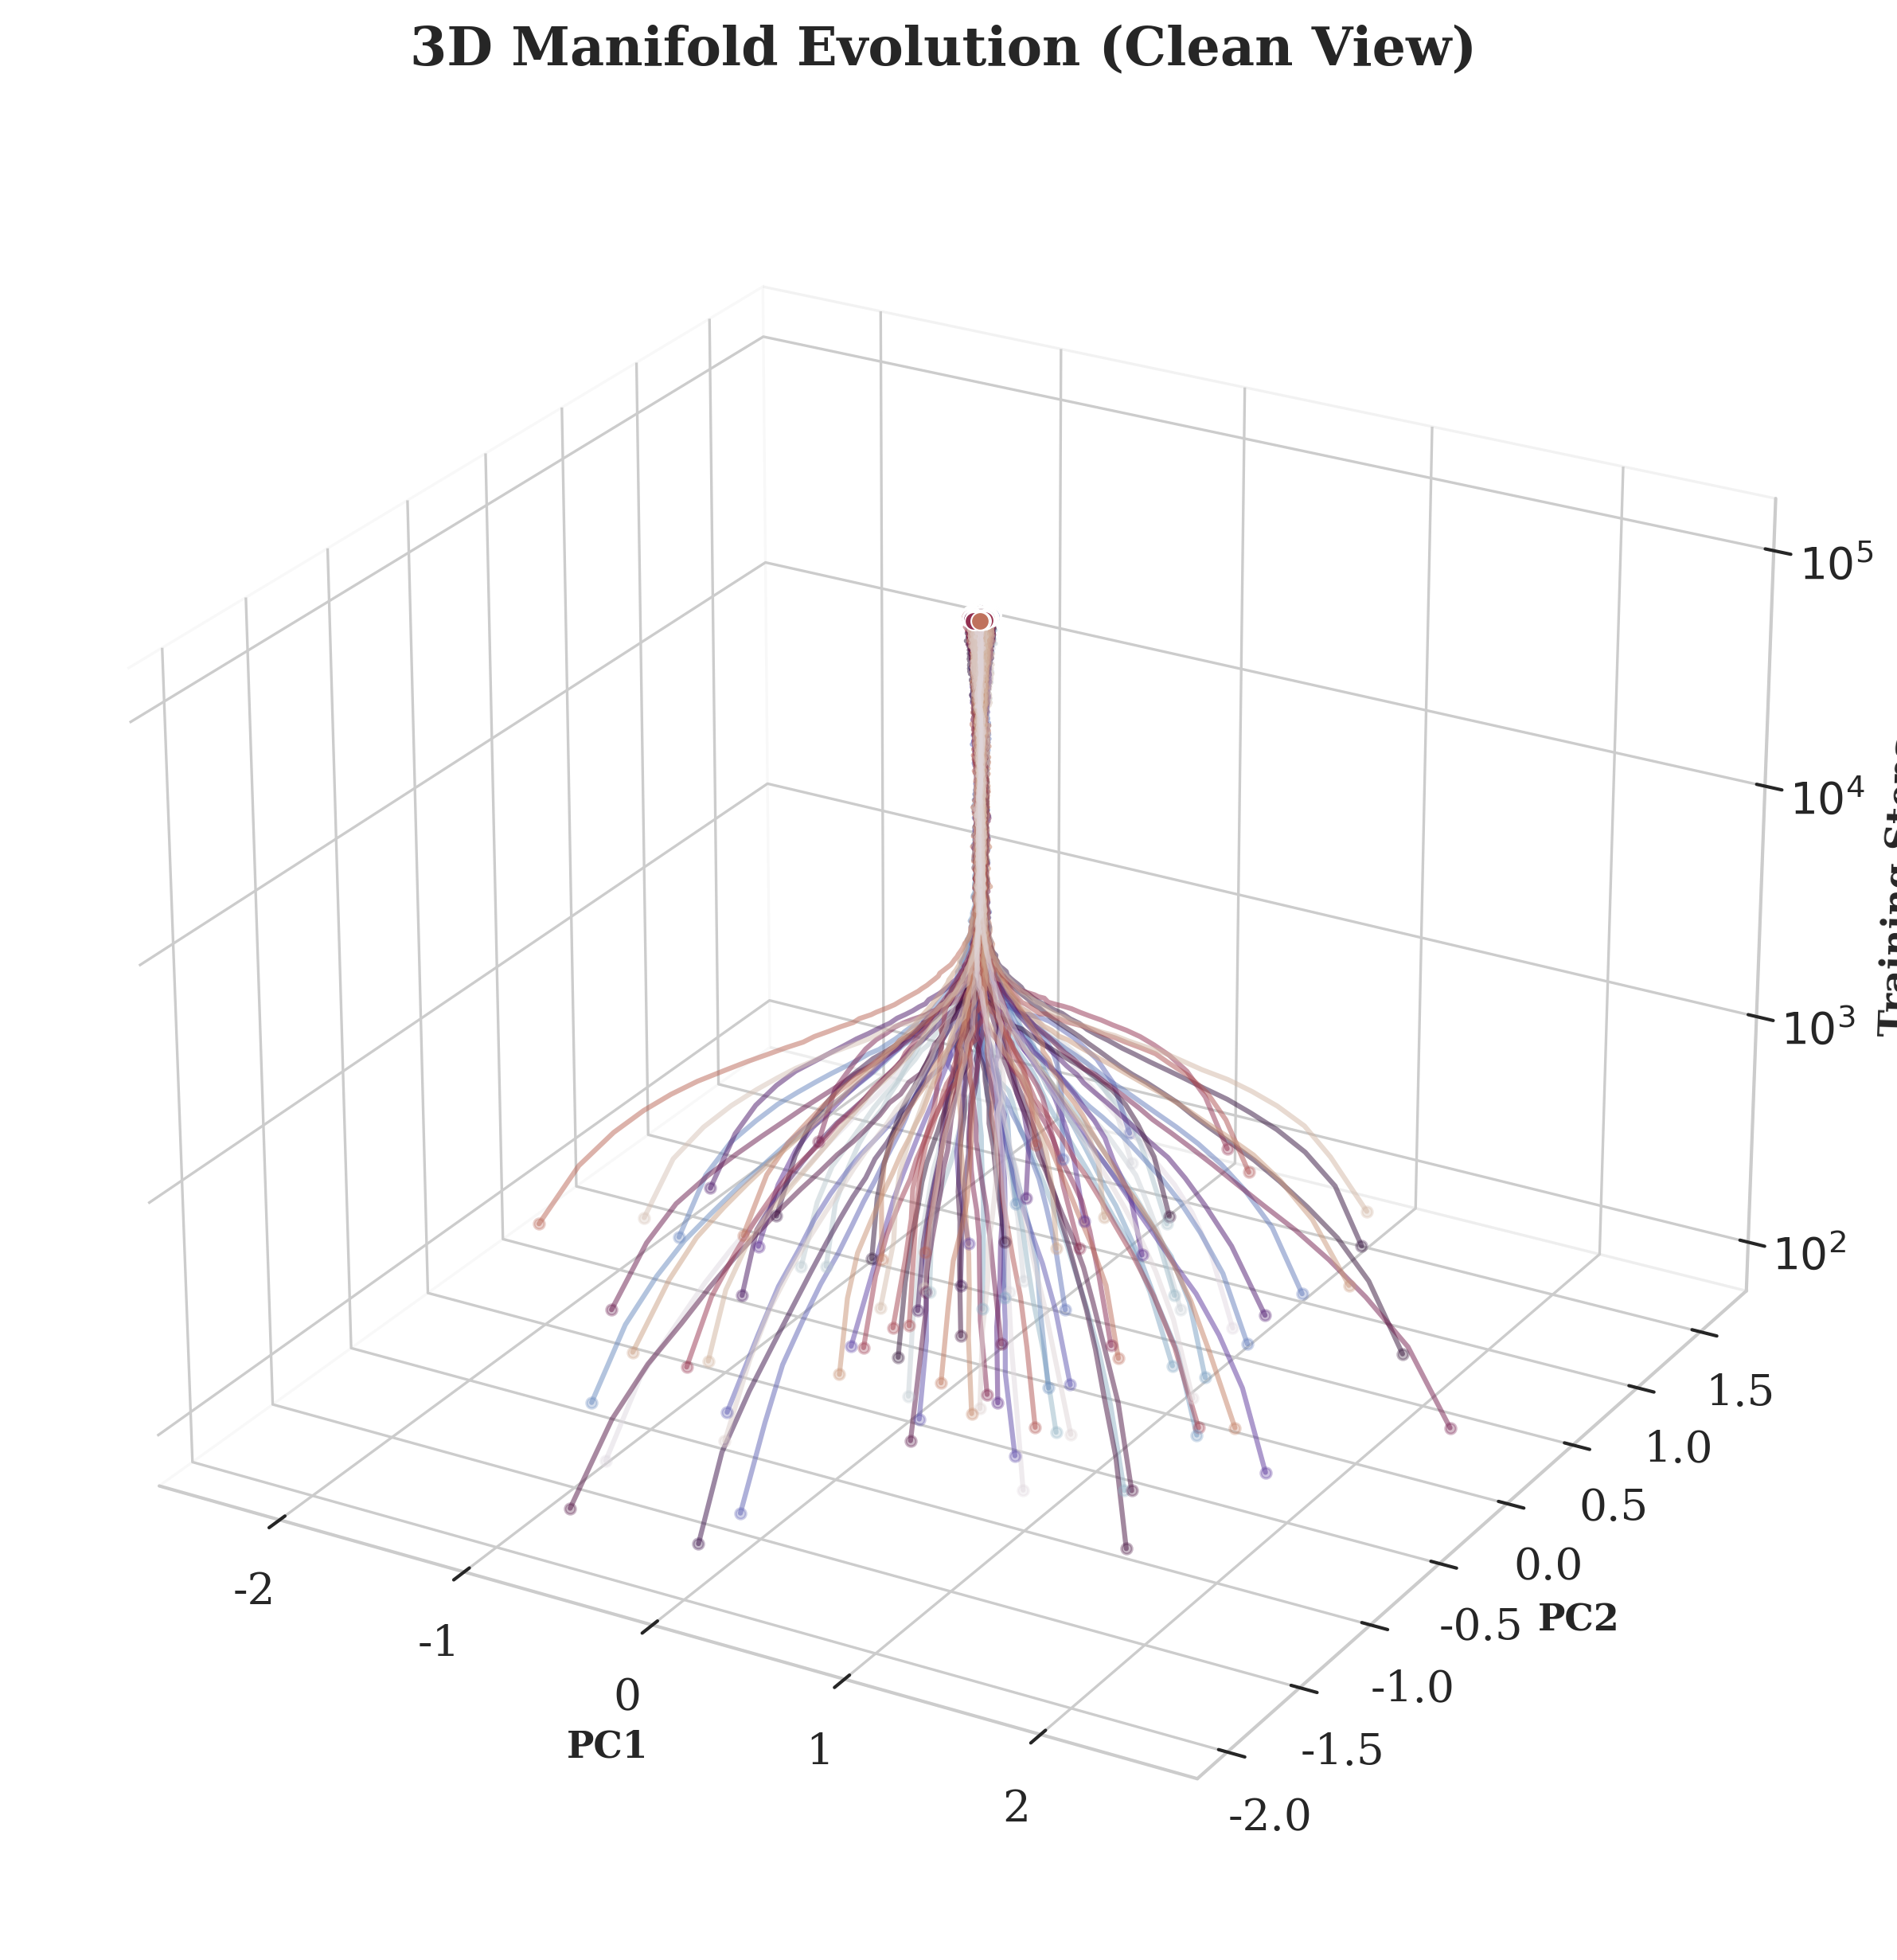

Saved 2D plot to ../results/Figure/manifold_final_state_wd1_stride8.png


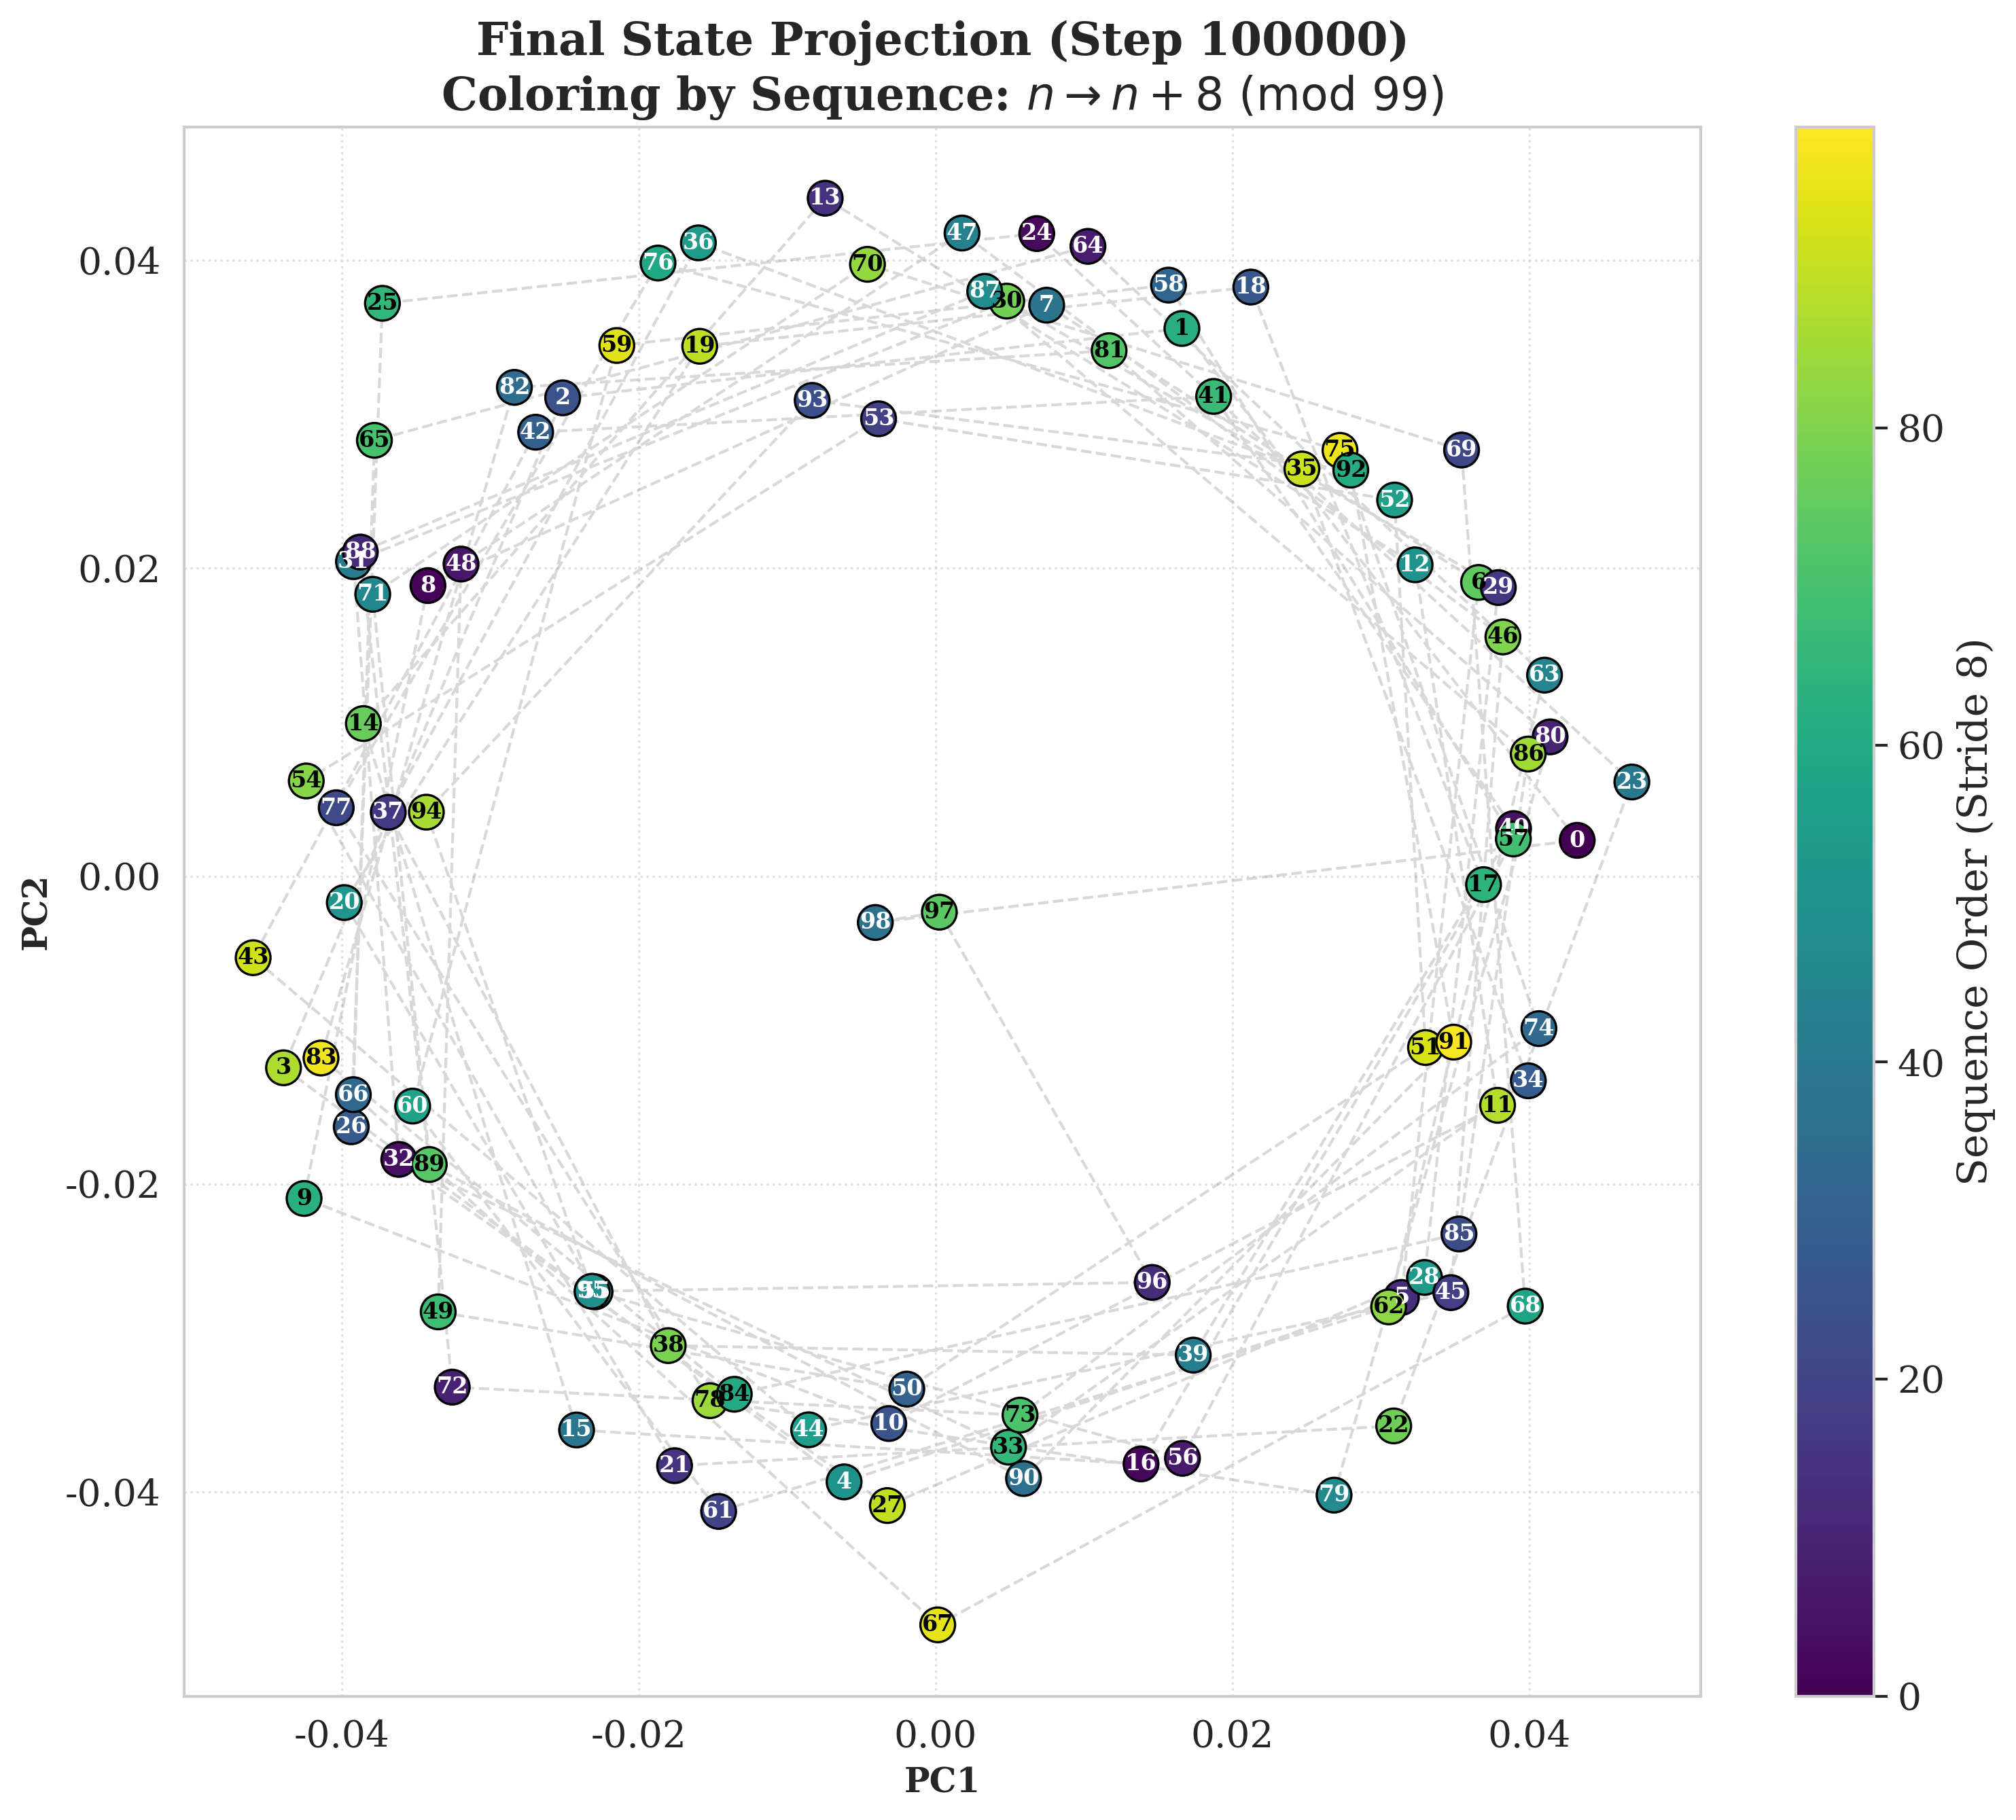

In [25]:
# Load PCA Trajectory Data
pca_csv_path = "../results/Data/t-sne/pca_trajectory_wd1.csv"

if os.path.exists(pca_csv_path):
    # Load and clean data
    df_pca = pd.read_csv(pca_csv_path)
    df_pca = df_pca.dropna(subset=['token_id', 'step', 'pc1', 'pc2'])
    
    # Get unique tokens
    tokens = np.sort(df_pca['token_id'].unique())
    num_tokens = len(tokens)
    max_step = df_pca['step'].max()
    
    if num_tokens == 0:
        print("Error: No tokens found in the data.")
    else:
        # Infer Modulus P (assuming tokens are 0..P-1)
        max_token_val = int(tokens.max())
        modulus = max_token_val + 1
        
        # ==========================================
        # Figure 1: 3D Manifold Evolution (Clean)
        # ==========================================
        try:
            fig = plt.figure(figsize=(12, 10))
            ax = fig.add_subplot(111, projection='3d')
            
            # Colormap for 3D plot: Cyclic to show ring structure
            cmap_3d = plt.get_cmap('twilight') 
            
            print(f"Plotting 3D Manifold for {num_tokens} tokens (P={modulus})...")
            
            for i, token in enumerate(tokens):
                traj = df_pca[df_pca['token_id'] == token].sort_values('step')
                xs = traj['pc1'].values
                ys = traj['pc2'].values
                steps = traj['step'].values
                
                # Avoid log(0)
                steps = np.maximum(steps, 1)
                zs = np.log10(steps)
                
                color = cmap_3d(i / num_tokens)
                
                ax.plot(xs, ys, zs, color=color, alpha=0.5, linewidth=1.5)
                ax.scatter(xs[-1], ys[-1], zs[-1], color=color, s=30, edgecolors='white', linewidth=0.5)
                ax.scatter(xs[0], ys[0], zs[0], color=color, s=10, alpha=0.3)

            # Z-axis formatting
            min_step = df_pca['step'].min()
            max_step_val = df_pca['step'].max()
            if min_step > 0:
                min_log_step = np.floor(np.log10(min_step))
                max_log_step = np.ceil(np.log10(max_step_val))
                z_ticks = np.arange(min_log_step, max_log_step + 1)
                z_labels = [f'$10^{int(i)}$' for i in z_ticks]
                ax.set_zticks(z_ticks)
                ax.set_zticklabels(z_labels)
            
            ax.set_xlabel('PC1', fontsize=11, labelpad=5, fontweight='bold')
            ax.set_ylabel('PC2', fontsize=11, labelpad=5, fontweight='bold')
            ax.set_zlabel('Training Steps', fontsize=11, labelpad=5, fontweight='bold')
            ax.set_title('3D Manifold Evolution (Clean View)', fontsize=16, fontweight='bold', pad=10)
            ax.view_init(elev=25, azim=-60)
            ax.xaxis.pane.fill = False; ax.yaxis.pane.fill = False; ax.zaxis.pane.fill = False
            ax.grid(True, linestyle='--', alpha=0.3)
            
            plt.tight_layout()
            save_path_3d = "../results/Figure/manifold_evolution_pca_wd1_clean.png"
            os.makedirs(os.path.dirname(save_path_3d), exist_ok=True)
            plt.savefig(save_path_3d, dpi=300, bbox_inches='tight')
            print(f"Saved 3D plot to {save_path_3d}")
            plt.show()
            plt.close(fig)
        except Exception as e:
            print(f"Error plotting 3D figure: {e}")
            import traceback
            traceback.print_exc()
        
        # ==========================================
        # Figure 2: 2D Final State (Stride-8 Coloring)
        # ==========================================
        try:
            fig2, ax2 = plt.subplots(figsize=(12, 10))
            
            final_df = df_pca[df_pca['step'] == max_step].sort_values('token_id')
            
            if final_df.empty:
                print("Error: No data found for the final step.")
            else:
                # Logic: Color deepens based on sequence 0, 8, 16...
                stride = 8
                
                # Generate the sequence: 0, 8, 16... mod P
                sequence = []
                visited = set()
                curr = 0
                for _ in range(modulus):
                    if curr not in visited:
                        sequence.append(curr)
                        visited.add(curr)
                    curr = (curr + stride) % modulus
                    
                # Fill any remaining numbers
                for i in range(modulus):
                    if i not in visited:
                        sequence.append(i)
                
                # Map token_id -> rank (0 to P-1)
                token_rank = {token: rank for rank, token in enumerate(sequence)}
                
                # Assign colors based on rank
                cmap_2d = plt.get_cmap('viridis')
                
                colors = []
                for t in final_df['token_id']:
                    t_int = int(t)
                    rank = token_rank.get(t_int, 0)
                    colors.append(cmap_2d(rank / modulus))
                
                # Plot Ring Structure (Connect 0-1-2...)
                pc1_vals = final_df['pc1'].values
                pc2_vals = final_df['pc2'].values
                
                if len(pc1_vals) > 0:
                    pc1_cycle = np.concatenate([pc1_vals, [pc1_vals[0]]])
                    pc2_cycle = np.concatenate([pc2_vals, [pc2_vals[0]]])
                    ax2.plot(pc1_cycle, pc2_cycle, color='gray', alpha=0.3, linestyle='--', linewidth=1, label='Ring Structure (0-1-2...)')
                
                # Scatter points with Stride-8 coloring
                scatter = ax2.scatter(final_df['pc1'], final_df['pc2'], c=colors, s=150, edgecolors='k', linewidth=0.8, zorder=2)
                
                # Annotate numbers
                for idx, row in final_df.iterrows():
                    token_id = int(row['token_id'])
                    # Determine text color based on background intensity (rank)
                    # Viridis is dark at 0, light at 1? No, Viridis is dark purple at 0, yellow at 1.
                    # So low rank (purple) -> white text. High rank (yellow) -> black text.
                    rank = token_rank.get(token_id, 0)
                    text_color = 'white' if rank < modulus * 0.6 else 'black'
                    
                    ax2.text(row['pc1'], row['pc2'], str(token_id), 
                             fontsize=8, fontweight='bold', color=text_color,
                             ha='center', va='center', zorder=3)

                # Add a colorbar
                sm = plt.cm.ScalarMappable(cmap=cmap_2d, norm=plt.Normalize(vmin=0, vmax=modulus))
                sm.set_array([])
                cbar = plt.colorbar(sm, ax=ax2, label=f'Sequence Order (Stride {stride})')
                
                # Fix: Use standard LaTeX for mod instead of \pmod which Matplotlib might not support fully in all contexts
                ax2.set_title(f'Final State Projection (Step {max_step})\nColoring by Sequence: $n \\to n+{stride} \\ (\\mathrm{{mod}}\\ {modulus})$', 
                              fontsize=16, fontweight='bold')
                ax2.set_xlabel('PC1', fontsize=12, fontweight='bold')
                ax2.set_ylabel('PC2', fontsize=12, fontweight='bold')
                ax2.grid(True, linestyle=':', alpha=0.6)
                
                # Use bbox_inches='tight' in savefig instead of tight_layout if it causes issues
                # plt.tight_layout() 
                
                save_path_2d = "../results/Figure/manifold_final_state_wd1_stride8.png"
                plt.savefig(save_path_2d, dpi=300, bbox_inches='tight')
                print(f"Saved 2D plot to {save_path_2d}")
                plt.show()
                plt.close(fig2)
            
        except Exception as e:
            print(f"Error plotting 2D figure: {e}")
            import traceback
            traceback.print_exc()

else:
    print(f"Data file not found: {pca_csv_path}. Please run utils/t-sne.py first.")

Comparison plot saved to ../results/Figure/comparison_wd0_vs_wd1.png


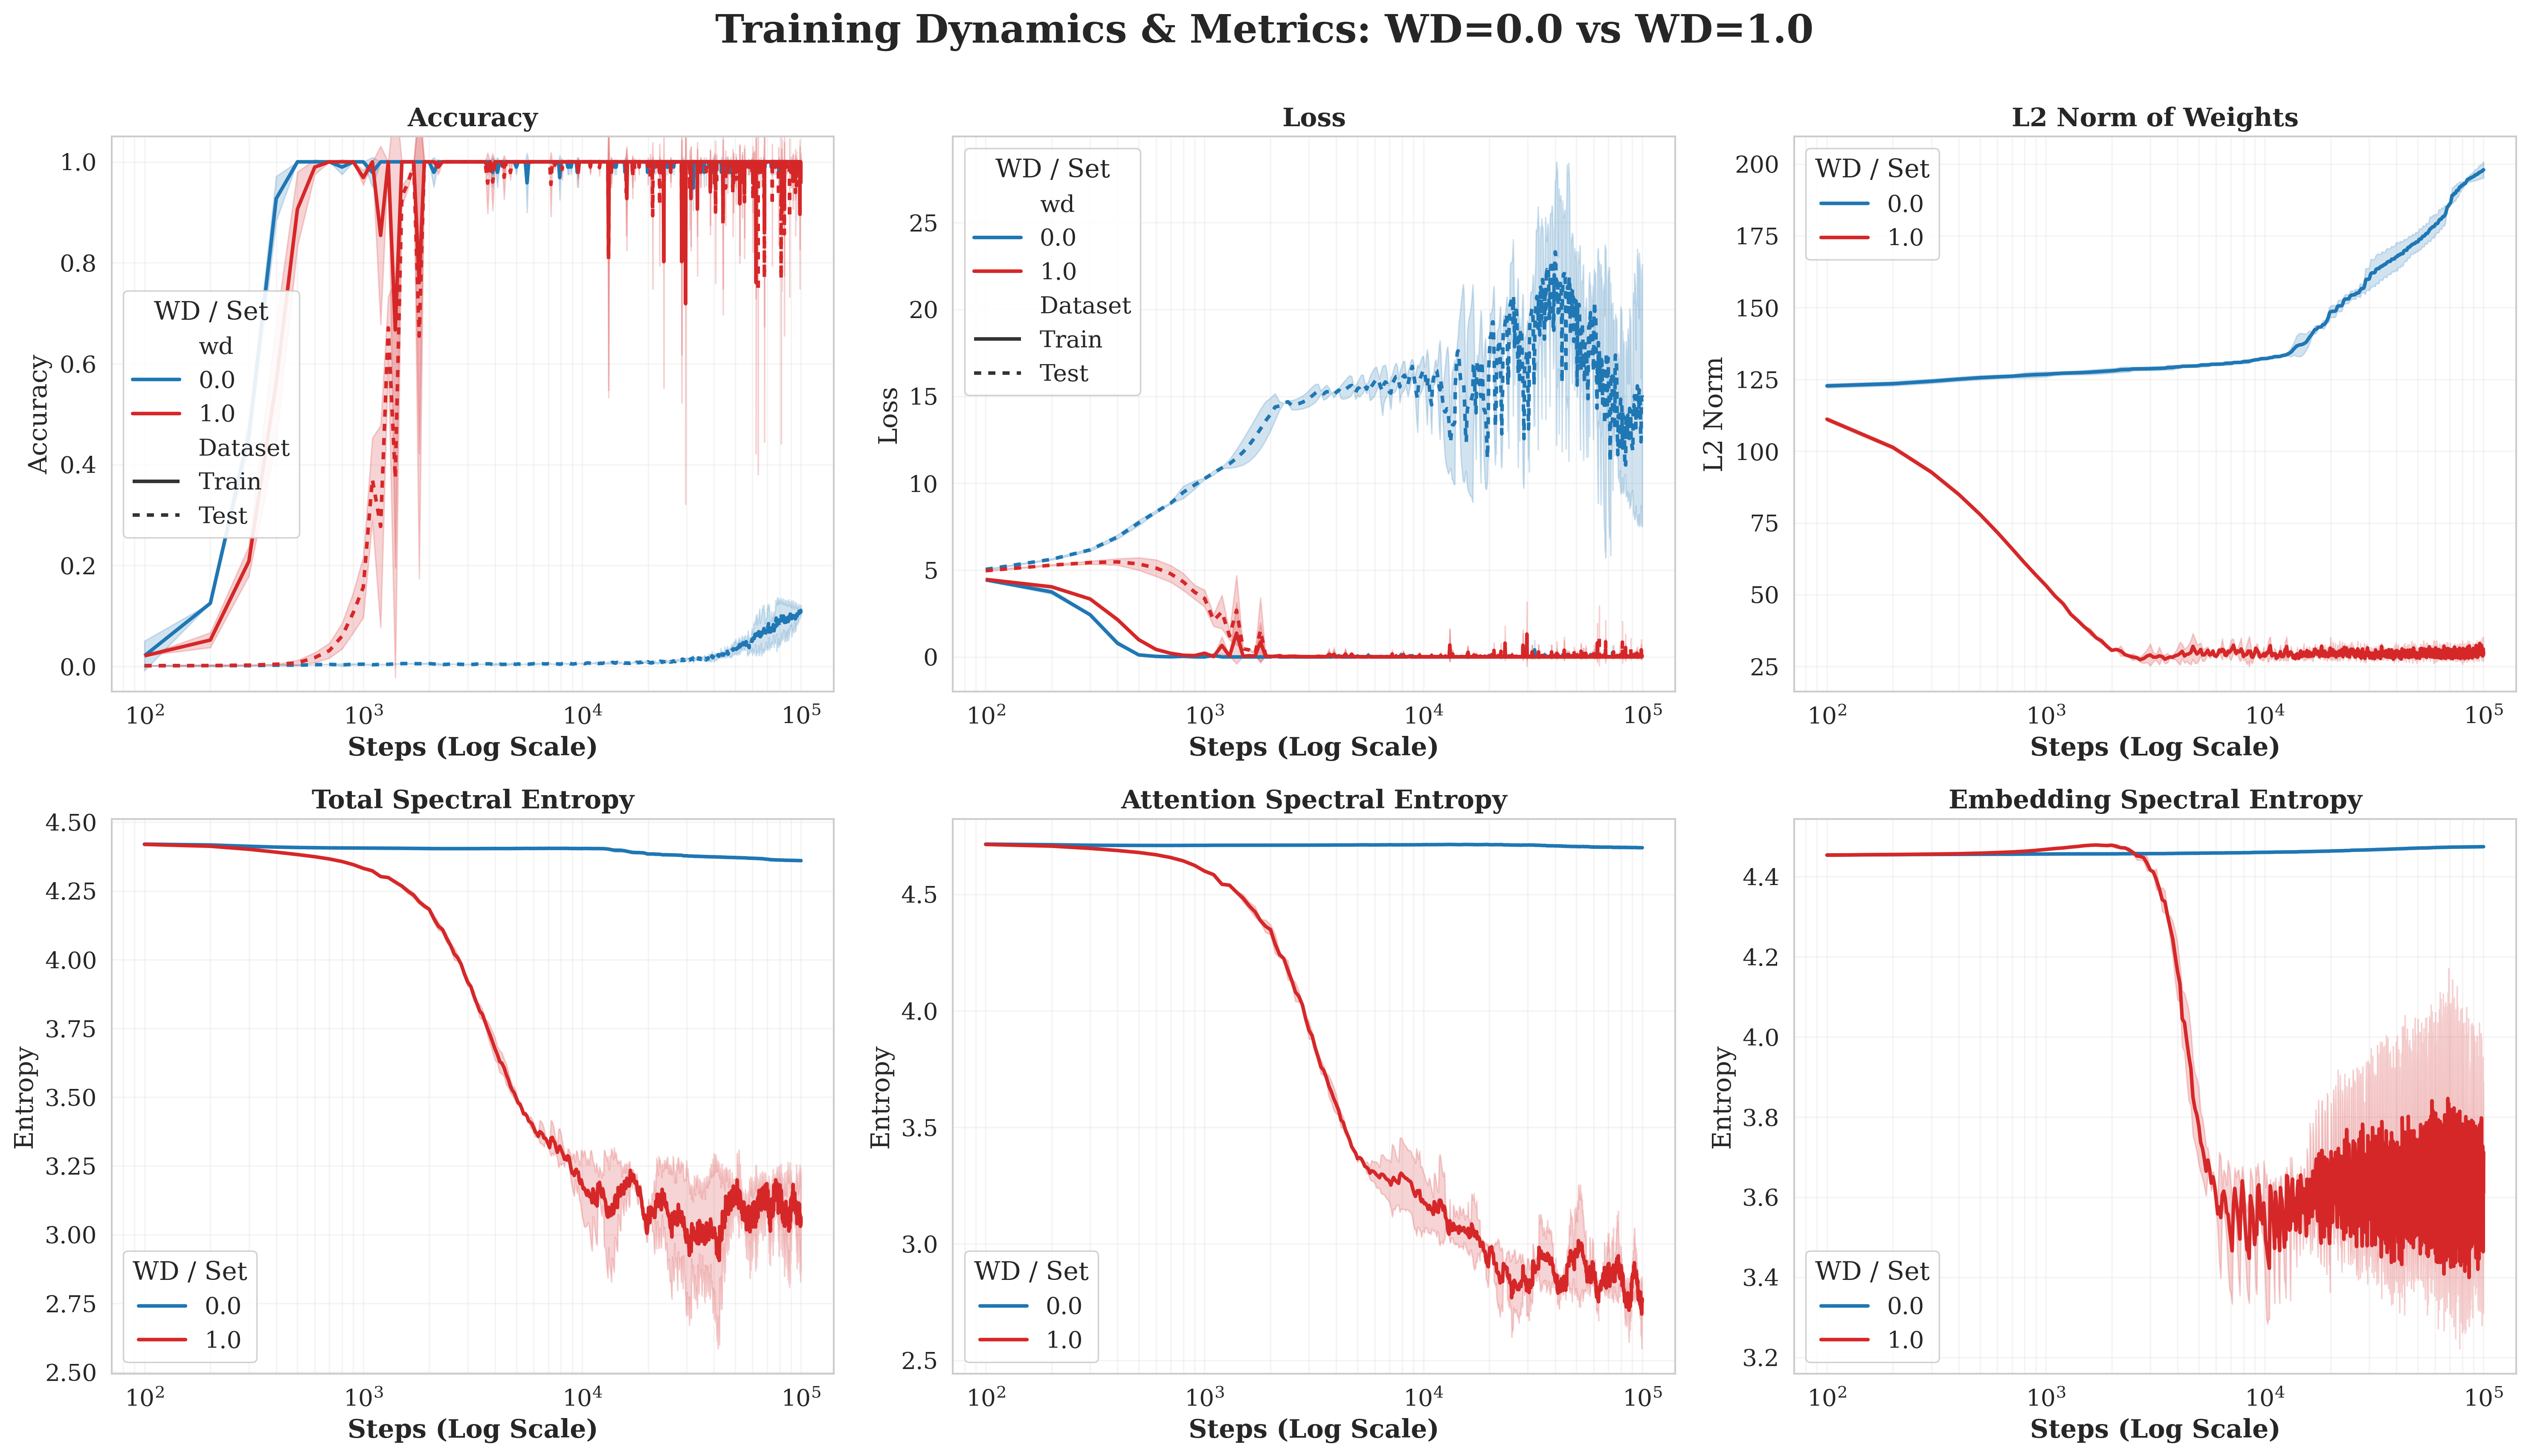

In [27]:
# ==========================================
# Comparative Analysis: WD=0.0 vs WD=1.0
# ==========================================
import matplotlib.ticker as ticker

# Define file paths
data_files = [
    {"path": "/data/zjj/test/results/data/x-y_wd_0.0_seed_42.csv", "wd": "0.0", "seed": 42},
    {"path": "/data/zjj/test/results/data/x-y_wd_0.0_seed_101.csv", "wd": "0.0", "seed": 101},
    {"path": "/data/zjj/test/results/data/x-y_wd_1.0_seed_42.csv", "wd": "1.0", "seed": 42},
    {"path": "/data/zjj/test/results/data/x-y_wd_1.0_seed_101.csv", "wd": "1.0", "seed": 101},
]

# Load and aggregate data
dfs = []
for entry in data_files:
    if os.path.exists(entry["path"]):
        df = pd.read_csv(entry["path"])
        df['wd'] = entry["wd"]
        df['seed'] = entry["seed"]
        dfs.append(df)
    else:
        print(f"Warning: File not found: {entry['path']}")

if dfs:
    full_df = pd.concat(dfs, ignore_index=True)
    
    # Setup figure with 2 rows, 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    
    # Common plotting parameters
    palette = {'0.0': '#1f77b4', '1.0': '#d62728'}
    
    # 1. Accuracy (Train & Test)
    # Melt to handle Train/Test style automatically
    df_acc = full_df.melt(id_vars=['steps', 'wd', 'seed'], value_vars=['train_acc', 'test_acc'], 
                          var_name='Dataset', value_name='Accuracy')
    df_acc['Dataset'] = df_acc['Dataset'].replace({'train_acc': 'Train', 'test_acc': 'Test'})
    
    sns.lineplot(data=df_acc, x='steps', y='Accuracy', hue='wd', style='Dataset', 
                 palette=palette, markers=False, dashes={'Train': (1, 0), 'Test': (2, 2)},
                 linewidth=2, errorbar='sd', ax=axes[0])
    
    axes[0].set_title('Accuracy', fontweight='bold')
    axes[0].set_ylim(-0.05, 1.05)
    
    # 2. Loss (Train & Test)
    df_loss = full_df.melt(id_vars=['steps', 'wd', 'seed'], value_vars=['train_loss', 'test_loss'], 
                           var_name='Dataset', value_name='Loss')
    df_loss['Dataset'] = df_loss['Dataset'].replace({'train_loss': 'Train', 'test_loss': 'Test'})
    
    sns.lineplot(data=df_loss, x='steps', y='Loss', hue='wd', style='Dataset', 
                 palette=palette, markers=False, dashes={'Train': (1, 0), 'Test': (2, 2)},
                 linewidth=2, errorbar='sd', ax=axes[1])
    
    axes[1].set_title('Loss', fontweight='bold')
    
    # 3. L2 Norm
    sns.lineplot(data=full_df, x='steps', y='l2_norm', hue='wd', 
                 palette=palette, linewidth=2, errorbar='sd', ax=axes[2])
    axes[2].set_title('L2 Norm of Weights', fontweight='bold')
    axes[2].set_ylabel('L2 Norm')
    
    # 4. Spectral Entropy
    sns.lineplot(data=full_df, x='steps', y='spectral_entropy', hue='wd', 
                 palette=palette, linewidth=2, errorbar='sd', ax=axes[3])
    axes[3].set_title('Total Spectral Entropy', fontweight='bold')
    axes[3].set_ylabel('Entropy')
    
    # 5. Attention Spectral Entropy
    sns.lineplot(data=full_df, x='steps', y='attention_spectral_entropy', hue='wd', 
                 palette=palette, linewidth=2, errorbar='sd', ax=axes[4])
    axes[4].set_title('Attention Spectral Entropy', fontweight='bold')
    axes[4].set_ylabel('Entropy')
    
    # 6. Embedding Spectral Entropy
    sns.lineplot(data=full_df, x='steps', y='embedding_spectral_entropy', hue='wd', 
                 palette=palette, linewidth=2, errorbar='sd', ax=axes[5])
    axes[5].set_title('Embedding Spectral Entropy', fontweight='bold')
    axes[5].set_ylabel('Entropy')
    
    # Formatting
    for ax in axes:
        ax.set_xscale('log')
        ax.set_xlabel('Steps (Log Scale)', fontweight='bold')
        ax.grid(True, which="both", ls="-", alpha=0.2)
        
        # Set Log Locator for X-axis to ensure 10^x ticks are visible
        ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
        ax.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=10))
        
        # Clean up legend
        if ax.get_legend():
            ax.legend(title='WD / Set', loc='best', frameon=True, framealpha=0.9)

    plt.suptitle("Training Dynamics & Metrics: WD=0.0 vs WD=1.0", fontsize=22, fontweight='bold', y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    save_path_comp = "../results/Figure/comparison_wd0_vs_wd1.png"
    os.makedirs(os.path.dirname(save_path_comp), exist_ok=True)
    plt.savefig(save_path_comp, dpi=300, bbox_inches='tight')
    print(f"Comparison plot saved to {save_path_comp}")
    plt.show()
else:
    print("No data loaded.")

Saved BDM trajectory plot to ../results/Figure/bdm_trajectory.png


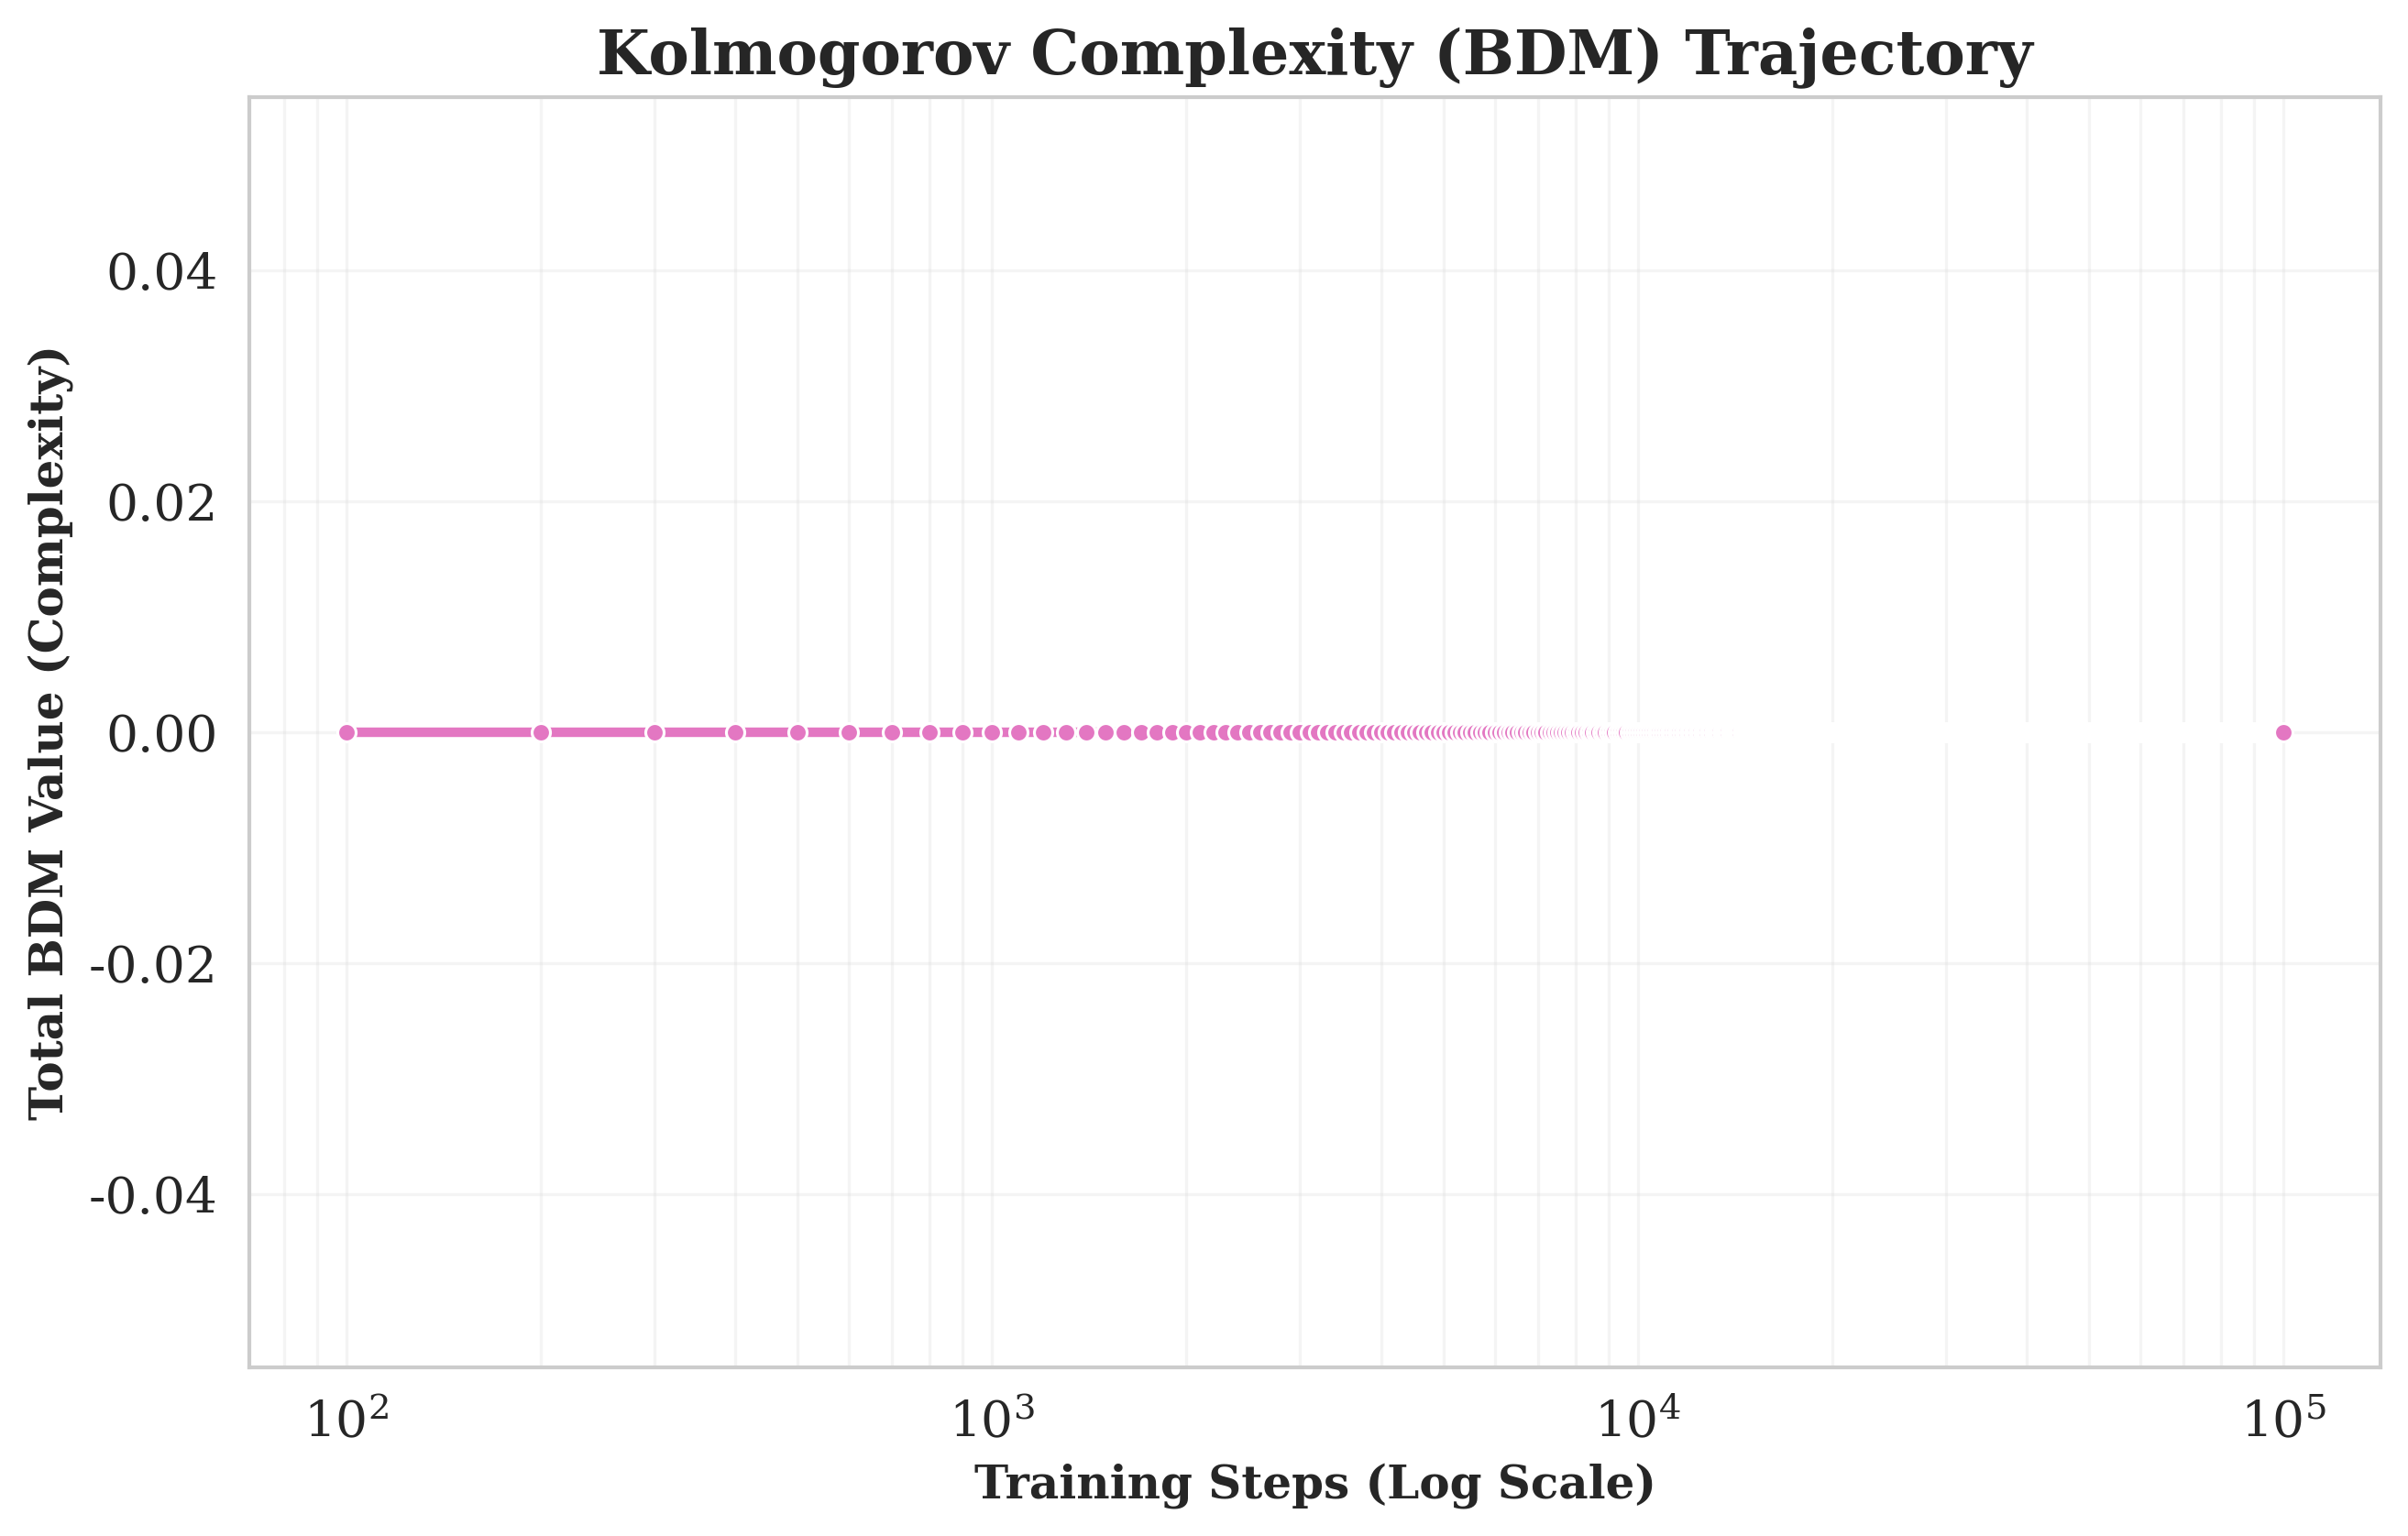

Processing step 100...
Error processing ../results/checkpoint_transformer_2_4_128/x-y/wd_1.0/seed42_step100.pt: 'int' object has no attribute 'dim'
Processing step 1000...
Error processing ../results/checkpoint_transformer_2_4_128/x-y/wd_1.0/seed42_step1000.pt: 'int' object has no attribute 'dim'
Processing step 10000...
Error processing ../results/checkpoint_transformer_2_4_128/x-y/wd_1.0/seed42_step10000.pt: 'int' object has no attribute 'dim'
Processing step 100000...
Error processing ../results/checkpoint_transformer_2_4_128/x-y/wd_1.0/seed42_step100000.pt: 'int' object has no attribute 'dim'
No checkpoint data found to visualize.


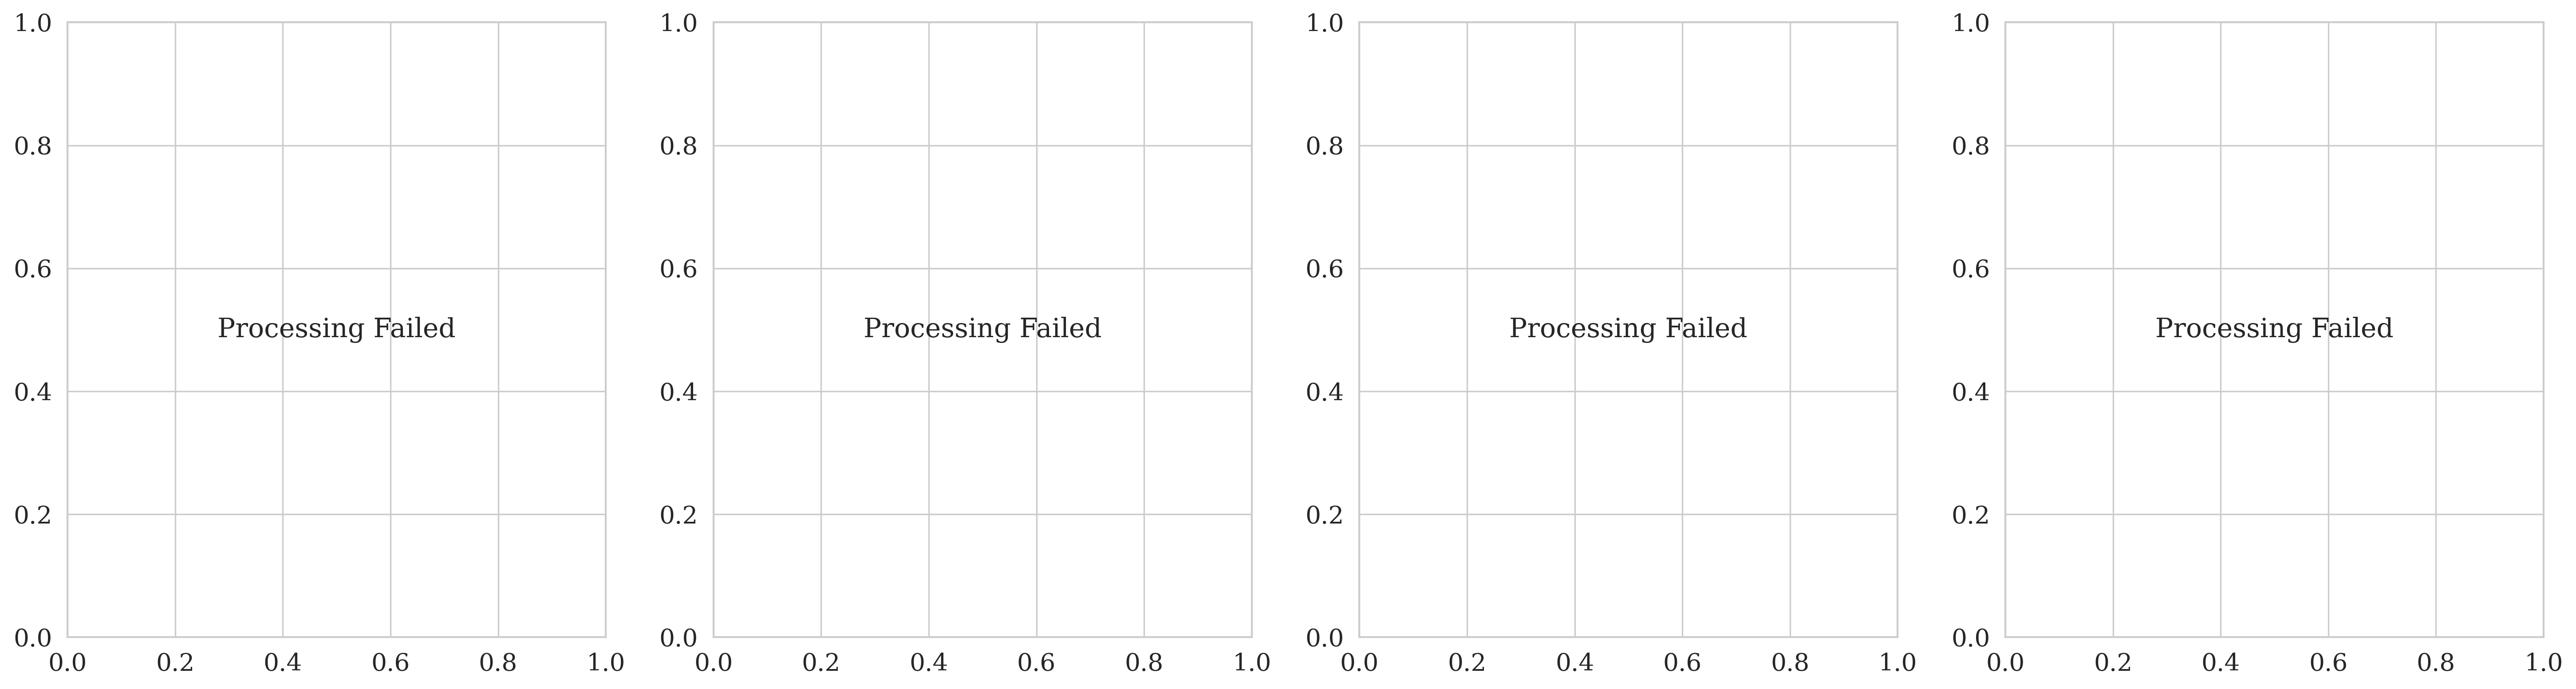

In [28]:
# ==========================================
# BDM Trajectory & Weight Clustering Visualization
# ==========================================
import torch
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap

# 1. Load BDM Trajectory
bdm_csv_path = "../results/Data/BDM/bdm_trajectory.csv"
if os.path.exists(bdm_csv_path):
    df_bdm = pd.read_csv(bdm_csv_path)
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_bdm, x='Step', y='Total_BDM_Value', marker='o', linewidth=2.5, color='#e377c2')
    plt.title('Kolmogorov Complexity (BDM) Trajectory', fontsize=16, fontweight='bold')
    plt.xlabel('Training Steps (Log Scale)', fontsize=12, fontweight='bold')
    plt.ylabel('Total BDM Value (Complexity)', fontsize=12, fontweight='bold')
    plt.xscale('log')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    save_path_bdm = "../results/Figure/bdm_trajectory.png"
    plt.savefig(save_path_bdm, dpi=300, bbox_inches='tight')
    print(f"Saved BDM trajectory plot to {save_path_bdm}")
    plt.show()
else:
    print(f"BDM CSV not found at {bdm_csv_path}")

# 2. On-the-fly Quantization & Clustering Visualization
checkpoint_dir = "../results/checkpoint_transformer_2_4_128/x-y/wd_1.0"
target_steps = [100, 1000, 10000, 100000]
layer_keyword = "layers.0" # Target the first layer
sub_keyword = "weight"     # Ensure it's a weight matrix

def z_score_normalization(weights):
    mean = np.mean(weights)
    std = np.std(weights)
    if std == 0: return np.zeros_like(weights)
    return (weights - mean) / std

def get_quantized_map(fpath, n_clusters=4):
    try:
        model_data = torch.load(fpath, map_location='cpu')
        state_dict = model_data['model'] if 'model' in model_data else model_data
        
        # Find a suitable 2D weight matrix
        target_param = None
        target_name = ""
        
        # Priority search
        for name, param in state_dict.items():
            if layer_keyword in name and sub_keyword in name and param.dim() == 2:
                target_param = param
                target_name = name
                break
        
        # Fallback
        if target_param is None:
            for name, param in state_dict.items():
                if param.dim() == 2:
                    target_param = param
                    target_name = name
                    break
        
        if target_param is not None:
            weights = target_param.detach().cpu().numpy()
            norm_weights = z_score_normalization(weights)
            
            # K-Means
            shape = weights.shape
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            labels = kmeans.fit_predict(norm_weights.reshape(-1, 1))
            return labels.reshape(shape), target_name
            
    except Exception as e:
        print(f"Error processing {fpath}: {e}")
    return None, None

# Setup Plot
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
cmap = ListedColormap(sns.color_palette("viridis", 4).as_hex())

found_data = False
for idx, step in enumerate(target_steps):
    fname = f"seed42_step{step}.pt"
    fpath = os.path.join(checkpoint_dir, fname)
    
    ax = axes[idx]
    
    if os.path.exists(fpath):
        print(f"Processing step {step}...")
        quantized_map, layer_name = get_quantized_map(fpath)
        
        if quantized_map is not None:
            found_data = True
            sns.heatmap(quantized_map, ax=ax, cmap=cmap, cbar=False, xticklabels=False, yticklabels=False)
            ax.set_title(f"Step {step}\n{layer_name}", fontsize=14, fontweight='bold')
            ax.set_xlabel(f"Shape: {quantized_map.shape}")
        else:
            ax.text(0.5, 0.5, "Processing Failed", ha='center', va='center')
    else:
        ax.text(0.5, 0.5, f"File not found:\n{fname}", ha='center', va='center')
        ax.set_title(f"Step {step}")

if found_data:
    plt.suptitle(f"Evolution of Weight Clustering (K=4) - WD=1.0", fontsize=20, fontweight='bold', y=1.05)
    plt.tight_layout()
    save_path_cluster = "../results/Figure/weight_clustering_evolution.png"
    plt.savefig(save_path_cluster, dpi=300, bbox_inches='tight')
    print(f"Saved clustering visualization to {save_path_cluster}")
    plt.show()
else:
    print("No checkpoint data found to visualize.")